# Setup

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import DenseNet201, EfficientNetB3, ResNet50
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import gc
from tensorflow.keras import backend as K
import itertools
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(42)
np.random.seed(42)


USE_AUGMENTATION_AND_OVERSAMPLING = False
print(f"Using augmentation and oversampling: {USE_AUGMENTATION_AND_OVERSAMPLING}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using augmentation and oversampling: False


In [15]:
import tensorflow_hub as hub
from PIL import Image
import time

SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

class SuperResolution:
    def __init__(self, model_path=SAVED_MODEL_PATH, cache_dir=None):
        print("Loading super-resolution model...")
        if cache_dir:
            os.makedirs(cache_dir, exist_ok=True)
            os.environ['TFHUB_CACHE_DIR'] = cache_dir

        self.model = hub.load(model_path)
        print("Super-resolution model loaded successfully!")

    def preprocess_image(self, image_path):
        hr_image = tf.image.decode_image(tf.io.read_file(image_path))

        if hr_image.shape[-1] == 4:
            hr_image = hr_image[...,:-1]
        hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
        hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
        hr_image = tf.cast(hr_image, tf.float32)
        return tf.expand_dims(hr_image, 0)

    def enhance_image(self, image_path, output_path=None):
        hr_image = self.preprocess_image(image_path)

        fake_image = self.model(hr_image)
        fake_image = tf.squeeze(fake_image)

        enhanced_image = tf.clip_by_value(fake_image, 0, 255)
        enhanced_image = tf.cast(enhanced_image, tf.uint8).numpy()

        if output_path:
            output_dir = os.path.dirname(output_path)
            if output_dir:
                os.makedirs(output_dir, exist_ok=True)
            image = Image.fromarray(enhanced_image)
            image.save(output_path)

        return enhanced_image

    def batch_enhance(self, image_paths, output_dir=None, max_images=None):
        enhanced_paths = {}

        if max_images:
            image_paths = image_paths[:max_images]

        total = len(image_paths)
        start_time = time.time()

        for idx, path in enumerate(image_paths):
            if idx % 10 == 0:
                elapsed = time.time() - start_time
                images_per_sec = max(1, idx) / elapsed
                remaining = (total - idx) / images_per_sec if idx > 0 else 0
                print(f"Processing image {idx+1}/{total} - {images_per_sec:.2f} img/s - Est. remaining: {remaining/60:.1f}m")

            if output_dir:
                filename = os.path.basename(path)
                output_path = os.path.join(output_dir, f"sr_{filename}")
                self.enhance_image(path, output_path)
                enhanced_paths[path] = output_path
            else:
                self.enhance_image(path)
                enhanced_paths[path] = None

        print(f"Processed {len(enhanced_paths)} images in {time.time() - start_time:.2f} seconds")
        return enhanced_paths

# Preparing data

In [16]:
data_path = '/content/dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall(data_path)
zip_ref.close()

csv_path = os.path.join(data_path, 'HAM10000_metadata.csv')
images_part1 = os.path.join(data_path, 'HAM10000_images_part_1')
images_part2 = os.path.join(data_path, 'HAM10000_images_part_2')

df_data = pd.read_csv(csv_path).set_index('image_id')

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df_data.dx = df_data.dx.astype('category', copy=True)
df_data['label_numeric'] = df_data.dx.cat.codes
df_data['label'] = df_data.dx
df_data['lesion_type'] = df_data.dx.map(lesion_type_dict)

imageid_path_dict = {}

for image_folder in [images_part1, images_part2]:
    if os.path.exists(image_folder):
        for image_file in os.listdir(image_folder):
            if image_file.endswith('.jpg'):
                image_id = os.path.splitext(image_file)[0]
                imageid_path_dict[image_id] = os.path.join(image_folder, image_file)

df_data['path'] = df_data.index.map(lambda x: imageid_path_dict.get(x, None))

df_data = df_data.dropna(subset=['path'])

print(f"Total images loaded: {len(df_data)}")
print("\nDiagnosis distribution:")
dx_counts = df_data['dx'].value_counts()
for dx, count in dx_counts.items():
    print(f"{lesion_type_dict[dx]} ({dx}): {count} images")

Total images loaded: 10015

Diagnosis distribution:
Melanocytic nevi (nv): 6705 images
Melanoma (mel): 1113 images
Benign keratosis (bkl): 1099 images
Basal cell carcinoma (bcc): 514 images
Actinic keratoses (akiec): 327 images
Vascular lesions (vasc): 142 images
Dermatofibroma (df): 115 images


#  Data Visualization and Split

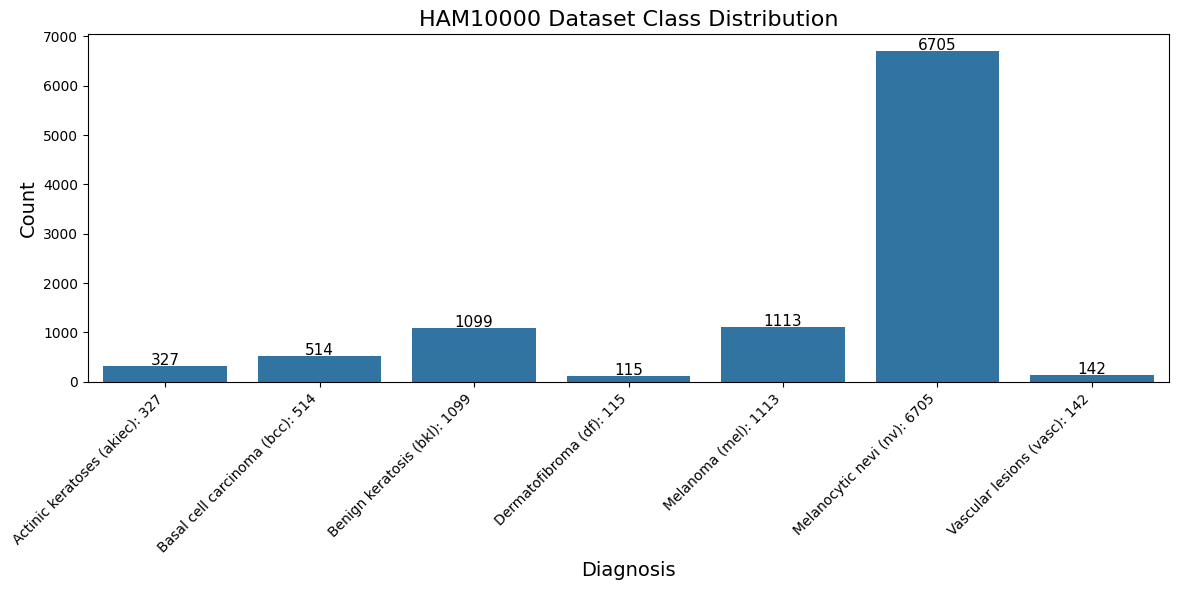

Duplicate lesion_ids: 2545 out of 10015


<ipython-input-17-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-17-68a55786744b>:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


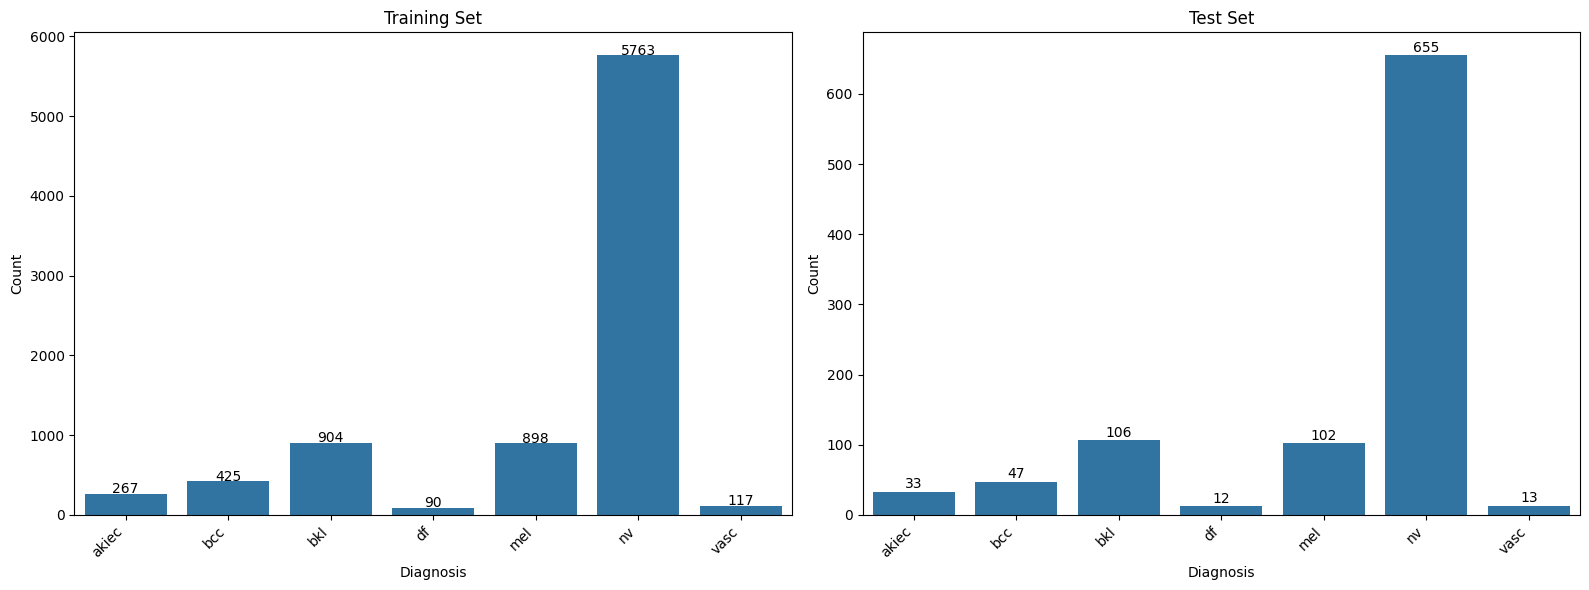

Training set: 8464 images
Test set: 968 images


In [17]:
def plot_data_distribution(df, title='Class Distribution'):
    plt.figure(figsize=(12, 6))
    counts = df['dx'].value_counts().sort_index()

    labels = [f"{lesion_type_dict[dx]} ({dx}): {count}" for dx, count in counts.items()]

    ax = sns.barplot(x=counts.index, y=counts.values)

    plt.title(title, fontsize=16)
    plt.xlabel('Diagnosis', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')

    for i, count in enumerate(counts.values):
        ax.text(i, count + 20, str(count), ha='center', fontsize=11)

    plt.tight_layout()
    plt.show()

plot_data_distribution(df_data, 'HAM10000 Dataset Class Distribution')

def check_duplicates(df, col='lesion_id'):
    unique_list = df[col].unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data)
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

df_train, df_test = train_test_split(df_data, test_size=0.1, stratify=df_data['label_numeric'], random_state=42)

df_test = df_test.reset_index()
df_train = df_train.reset_index()

df_test = df_test.drop_duplicates(subset='lesion_id', keep="first")

test_lesion_ids = set(df_test['lesion_id'].unique())
df_train = df_train[~df_train['lesion_id'].isin(test_lesion_ids)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (df, title) in enumerate([(df_train, 'Training Set'), (df_test, 'Test Set')]):
    counts = df['dx'].value_counts().sort_index()
    ax = axes[i]
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diagnosis')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for j, count in enumerate(counts.values):
        ax.text(j, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

print(f"Training set: {len(df_train)} images")
print(f"Test set: {len(df_test)} images")

# Data Augmentation and Balance Function

In [18]:
def balance_data(train_data, oversample=True):
    if not oversample:
        print("Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False")
        return train_data

    balanced_train_data = []
    class_counts = train_data['label_numeric'].value_counts()

    nv_indices = train_data[train_data['dx'] == 'nv'].index
    nv_label = list(train_data[train_data['dx'] == 'nv']['label_numeric'].unique())[0]

    for class_label, count in class_counts.items():
        class_data = train_data[train_data['label_numeric'] == class_label]
        class_name = list(train_data[train_data['label_numeric'] == class_label]['dx'].unique())[0]

        if class_label == nv_label:
            balanced_train_data.append(class_data)
            print(f"Class '{class_name}' (original): {len(class_data)} samples")
        else:
            if count < 1500:
                n_samples_needed = 1500
                n_oversample = n_samples_needed - count

                full_copies = n_oversample // count
                remaining = n_oversample % count

                oversampled = pd.concat([class_data] * full_copies) if full_copies > 0 else pd.DataFrame()

                if remaining > 0:
                    additional = class_data.sample(n=remaining, replace=False, random_state=42)
                    oversampled = pd.concat([oversampled, additional])

                final_class_data = pd.concat([class_data, oversampled])
                balanced_train_data.append(final_class_data)
                print(f"Class '{class_name}' (oversampled): {len(final_class_data)} samples (original: {count})")
            else:
                balanced_train_data.append(class_data.sample(n=1500, random_state=42))
                print(f"Class '{class_name}' (downsampled): 1500 samples (original: {count})")

    balanced_data = pd.concat(balanced_train_data)
    return balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

class SuperResolutionDataGenerator:
    def __init__(self, base_generator, sr_model=None, cache_dir=None):
        self.base_generator = base_generator

        if sr_model is None:
            self.sr_model = SuperResolution(cache_dir=cache_dir)
        else:
            self.sr_model = sr_model

        self.cache_dir = cache_dir
        if cache_dir:
            os.makedirs(cache_dir, exist_ok=True)

        self.enhanced_paths = {}

    def flow_from_dataframe(self, dataframe, x_col, y_col, target_size,
                           class_mode, color_mode, shuffle, batch_size, **kwargs):

        df_copy = dataframe.copy()

        print(f"Applying super-resolution to {len(df_copy)} images...")

        if len(df_copy) > 100:
            if self.cache_dir is None:
                self.cache_dir = os.path.join(os.getcwd(), 'sr_cache')
                os.makedirs(self.cache_dir, exist_ok=True)

            image_paths = df_copy[x_col].tolist()
            processed_paths = {}

            for idx, path in enumerate(image_paths):
                if idx % 100 == 0:
                    print(f"Processing image {idx+1}/{len(image_paths)}")

                filename = os.path.basename(path)
                enhanced_path = os.path.join(self.cache_dir, f"sr_{filename}")

                if not os.path.exists(enhanced_path):
                    try:
                        self.sr_model.enhance_image(path, enhanced_path)
                    except Exception as e:
                        print(f"Error enhancing image {path}: {e}")
                        enhanced_path = path

                processed_paths[path] = enhanced_path

            df_copy[x_col] = df_copy[x_col].map(lambda p: processed_paths.get(p, p))
            print(f"Super-resolution completed for {len(processed_paths)} images")

        return self.base_generator.flow_from_dataframe(
            df_copy,
            x_col=x_col,
            y_col=y_col,
            target_size=target_size,
            class_mode=class_mode,
            color_mode=color_mode,
            shuffle=shuffle,
            batch_size=batch_size,
            **kwargs
        )


common_aug_args = {
    "featurewise_center": False,
    "samplewise_center": False,
    "featurewise_std_normalization": False,
    "samplewise_std_normalization": False,
    "zca_whitening": False,
    "rotation_range": 10,
    "zoom_range": 0.1,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "horizontal_flip": False,
    "vertical_flip": False,
    "fill_mode": 'nearest'
}

if USE_AUGMENTATION_AND_OVERSAMPLING:
    tr_gen_rescale_base = ImageDataGenerator(rescale=1.0/255.0, **common_aug_args)
    tr_gen_no_rescale_base = ImageDataGenerator(**common_aug_args)
else:
    tr_gen_rescale_base = ImageDataGenerator(rescale=1.0/255.0)
    tr_gen_no_rescale_base = ImageDataGenerator()

ts_gen_rescale = ImageDataGenerator(rescale=1.0/255.0)
ts_gen_no_rescale = ImageDataGenerator()

print("Initializing super-resolution model...")
sr_model = SuperResolution(cache_dir='sr_cache')

sr_cache_dir = os.path.join(os.getcwd(), 'sr_cache')
tr_gen_rescale = SuperResolutionDataGenerator(tr_gen_rescale_base, sr_model=sr_model, cache_dir=sr_cache_dir)
tr_gen_no_rescale = SuperResolutionDataGenerator(tr_gen_no_rescale_base, sr_model=sr_model, cache_dir=sr_cache_dir)

Initializing super-resolution model...
Loading super-resolution model...
Super-resolution model loaded successfully!


# Models

In [19]:
def create_densenet_model(input_shape=(224, 224, 3), num_classes=7):
    base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_efficientnet_model(input_shape=(300, 300, 3), num_classes=7):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.6),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])

    return model

def create_resnet50_model(input_shape=(112, 150, 3), num_classes=7):
    base_model = ResNet50(
        include_top=False,
        input_shape=input_shape,
        pooling='avg',
        weights='imagenet'
    )

    model = Sequential([
        base_model,
        Dropout(0.5),
        Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.02))
    ])

    return model

def compile_model(model):
    opt = Adam(learning_rate=0.001)
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

model_configs = {
    "ResNet50": {"img_size": (112, 150), "use_rescale": True, "model_func": create_resnet50_model},
    "EfficientNetB3": {"img_size": (300, 300), "use_rescale": False, "model_func": create_efficientnet_model},
    "DenseNet201": {"img_size": (224, 224), "use_rescale": True, "model_func": create_densenet_model}

}

# Functions for Visualization

In [20]:
def plot_roc_curves(fpr, tpr, roc_auc, class_names, title='ROC Curves'):
    plt.figure(figsize=(12, 10))

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_training_history(history, model_name):
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Training')
    if 'val_auc' in history.history:
        plt.plot(history.history['val_auc'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# K-Fold Cross-Validation Training


Starting 5-Fold CV for model: ResNet50

--- Fold 1 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,887 (90.98 MB)

 Trainable params: 23,797,767 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 209s 710ms/step - accuracy: 0.6557 - auc: 0.9017 - loss: 4.2690 - val_accuracy: 0.6810 - val_auc: 0.8663 - val_loss: 1.6843 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 123s 580ms/step - accuracy: 0.7390 - auc: 0.9514 - loss: 1.1598 - val_accuracy: 0.6810 - val_auc: 0.8744 - val_loss: 1.4718 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 125s 587ms/step - accuracy: 0.7527 - auc: 0.9604 - loss: 0.8494 - val_accuracy: 0.6810 - val_auc: 0.9010 - val_loss: 1.2451 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 569ms/step - accuracy: 0.7758 - auc: 0.9653 - loss: 0.7568 - val_accuracy: 0.6822 - val_auc: 0.9061 - val_loss: 1.2187 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 570ms/step - accuracy: 0.7863 - auc: 0.9693 - loss: 0.7116 - val_accuracy: 0.6846 - val_auc: 0.8742 - val_loss: 1.9504 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 575ms/step - ac

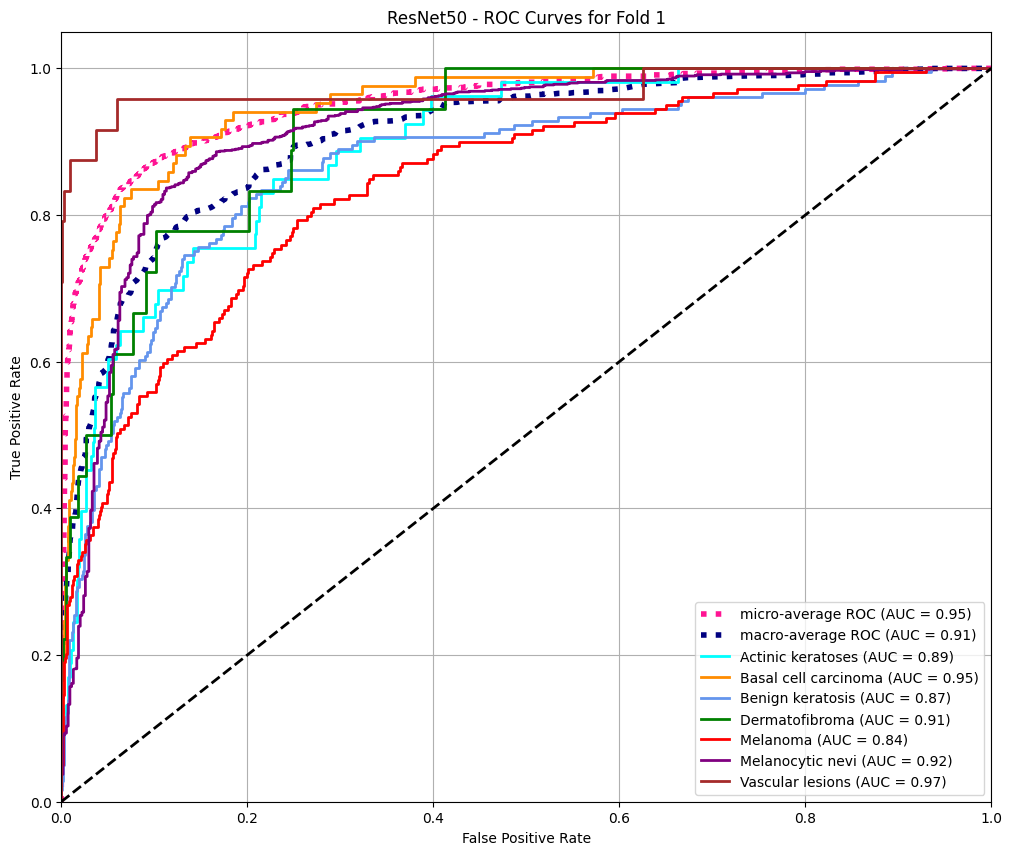


--- Fold 2 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 198s 678ms/step - accuracy: 0.6642 - auc: 0.9145 - loss: 3.9458 - val_accuracy: 0.6810 - val_auc: 0.8139 - val_loss: 23.9802 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 572ms/step - accuracy: 0.7070 - auc: 0.9398 - loss: 1.2060 - val_accuracy: 0.6810 - val_auc: 0.8797 - val_loss: 1.4854 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 124s 585ms/step - accuracy: 0.7548 - auc: 0.9590 - loss: 0.8354 - val_accuracy: 0.6810 - val_auc: 0.8154 - val_loss: 1.4657 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7731 - auc: 0.9647 - loss: 0.7580
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 575ms/step - accuracy: 0.7731 - auc: 0.9647 - loss: 0.7579 - val_accuracy: 0.0561 - val_auc: 0.6774 - val_loss: 2.2761 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 575ms/step - accuracy: 0.8014 - auc

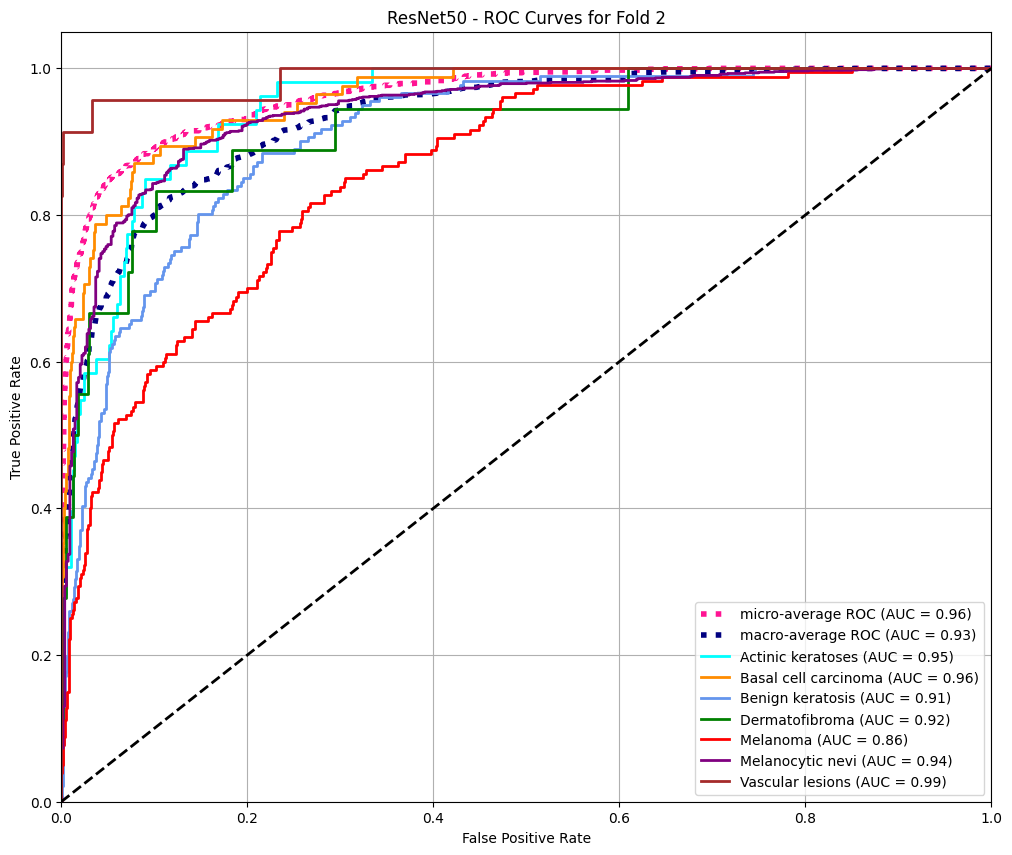


--- Fold 3 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 202s 699ms/step - accuracy: 0.6593 - auc: 0.9136 - loss: 3.9211 - val_accuracy: 0.6810 - val_auc: 0.8139 - val_loss: 483.9073 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 574ms/step - accuracy: 0.7265 - auc: 0.9478 - loss: 1.1063 - val_accuracy: 0.6810 - val_auc: 0.8934 - val_loss: 1.3200 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 126s 594ms/step - accuracy: 0.7667 - auc: 0.9618 - loss: 0.8090 - val_accuracy: 0.6810 - val_auc: 0.8790 - val_loss: 1.4898 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7674 - auc: 0.9632 - loss: 0.7732
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 568ms/step - accuracy: 0.7674 - auc: 0.9632 - loss: 0.7731 - val_accuracy: 0.6728 - val_auc: 0.8587 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 575ms/step - accuracy: 0.8077 - au

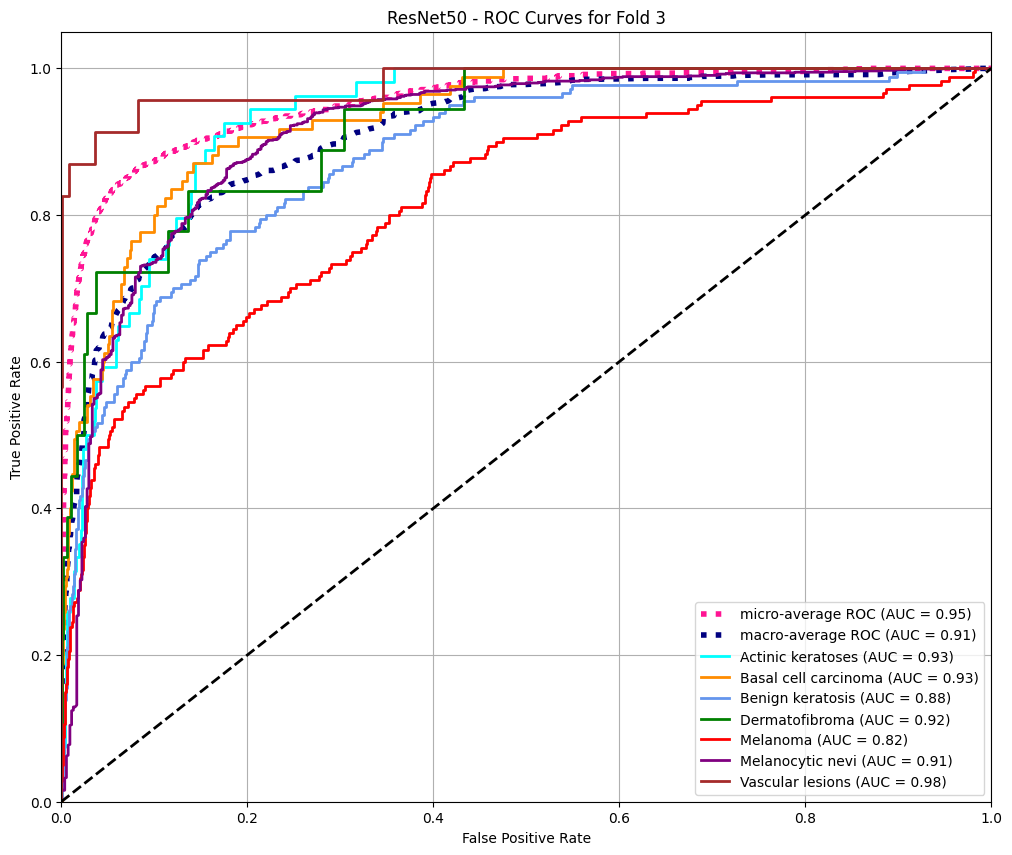


--- Fold 4 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 200s 687ms/step - accuracy: 0.6693 - auc: 0.9091 - loss: 4.1458 - val_accuracy: 0.6804 - val_auc: 0.8587 - val_loss: 1.8967 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 575ms/step - accuracy: 0.7101 - auc: 0.9444 - loss: 1.1901 - val_accuracy: 0.6804 - val_auc: 0.8400 - val_loss: 1.5824 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 123s 578ms/step - accuracy: 0.7379 - auc: 0.9540 - loss: 0.8973 - val_accuracy: 0.6804 - val_auc: 0.8400 - val_loss: 1.3260 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7570 - auc: 0.9592 - loss: 0.8088
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 125s 588ms/step - accuracy: 0.7570 - auc: 0.9592 - loss: 0.8087 - val_accuracy: 0.6409 - val_auc: 0.8783 - val_loss: 1.3769 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 127s 597ms/step - accuracy: 0.7900 - auc:

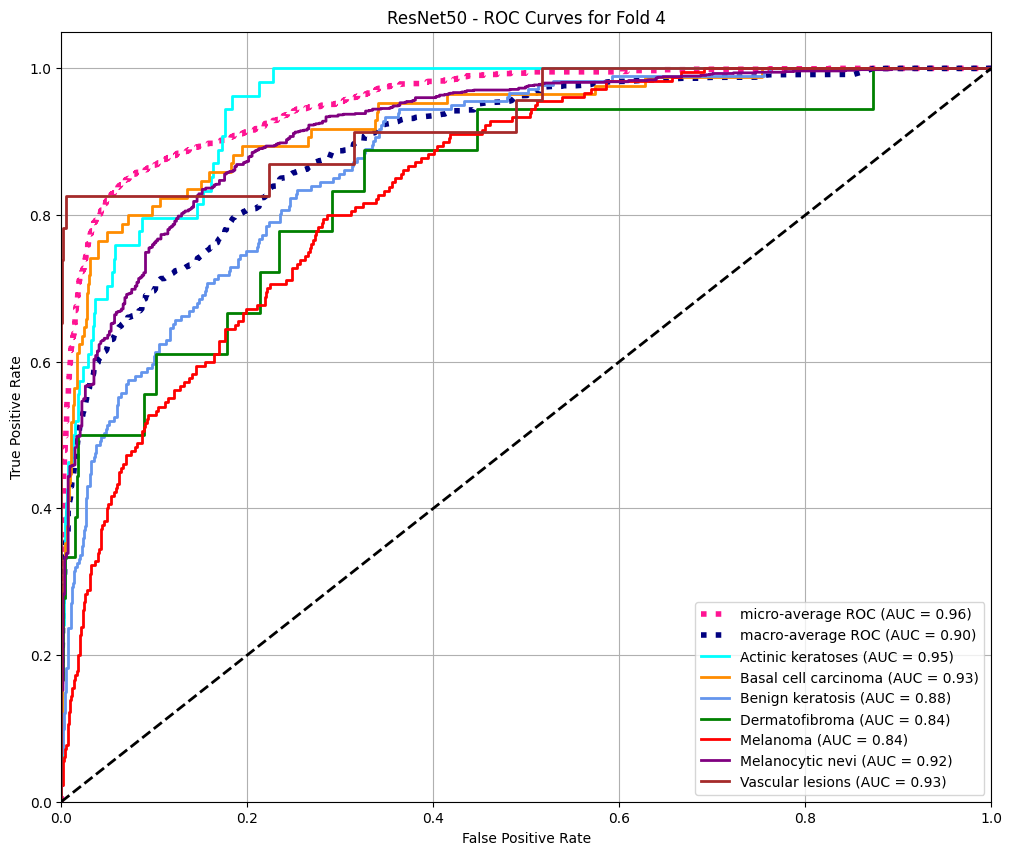


--- Fold 5 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6772 samples
Applying super-resolution to 6772 images...
Processing image 1/6772
Processing image 101/6772
Processing image 201/6772
Processing image 301/6772
Processing image 401/6772
Processing image 501/6772
Processing image 601/6772
Processing image 701/6772
Processing image 801/6772
Processing image 901/6772
Processing image 1001/6772
Processing image 1101/6772
Processing image 1201/6772
Processing image 1301/6772
Processing image 1401/6772
Processing image 1501/6772
Processing image 1601/6772
Processing image 1701/6772
Processing image 1801/6772
Processing image 1901/6772
Processing image 2001/6772
Processing image 2101/6772
Processing image 2201/6772
Processing image 2301/6772
Processing image 2401/6772
Processing image 2501/6772
Processing image 2601/6772
Processing image 2701/6772
Processing image 2801/6772
Processing image 2901/6772
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 204s 707ms/step - accuracy: 0.6787 - auc: 0.9174 - loss: 3.8048 - val_accuracy: 0.6809 - val_auc: 0.8449 - val_loss: 1.8016 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 123s 581ms/step - accuracy: 0.7360 - auc: 0.9523 - loss: 1.0673 - val_accuracy: 0.6809 - val_auc: 0.8545 - val_loss: 1.4616 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 123s 578ms/step - accuracy: 0.7687 - auc: 0.9619 - loss: 0.8243 - val_accuracy: 0.6809 - val_auc: 0.8691 - val_loss: 1.6656 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.7770 - auc: 0.9667 - loss: 0.7426
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
212/212 ━━━━━━━━━━━━━━━━━━━━ 119s 559ms/step - accuracy: 0.7770 - auc: 0.9667 - loss: 0.7426 - val_accuracy: 0.6655 - val_auc: 0.8970 - val_loss: 1.2859 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 571ms/step - accuracy: 0.8193 - auc:

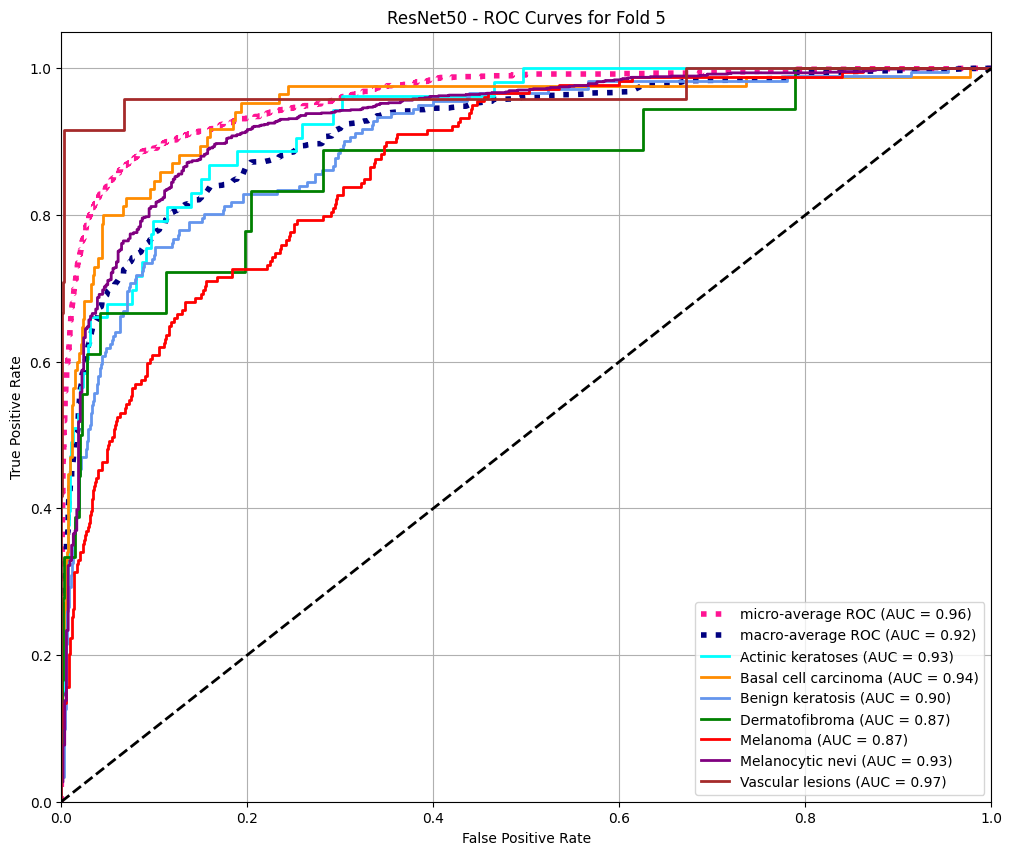


Model ResNet50 - CV Validation Accuracies for each fold: [0.7708210349082947, 0.8050797581672668, 0.7879503965377808, 0.7849970459938049, 0.8055555820465088]
Model ResNet50 - Mean Validation Accuracy: 0.7909
Model ResNet50 - CV Validation AUC for each fold: [0.9319272041320801, 0.9384174346923828, 0.9309390783309937, 0.923784077167511, 0.939033031463623]
Model ResNet50 - Mean Validation AUC: 0.9328


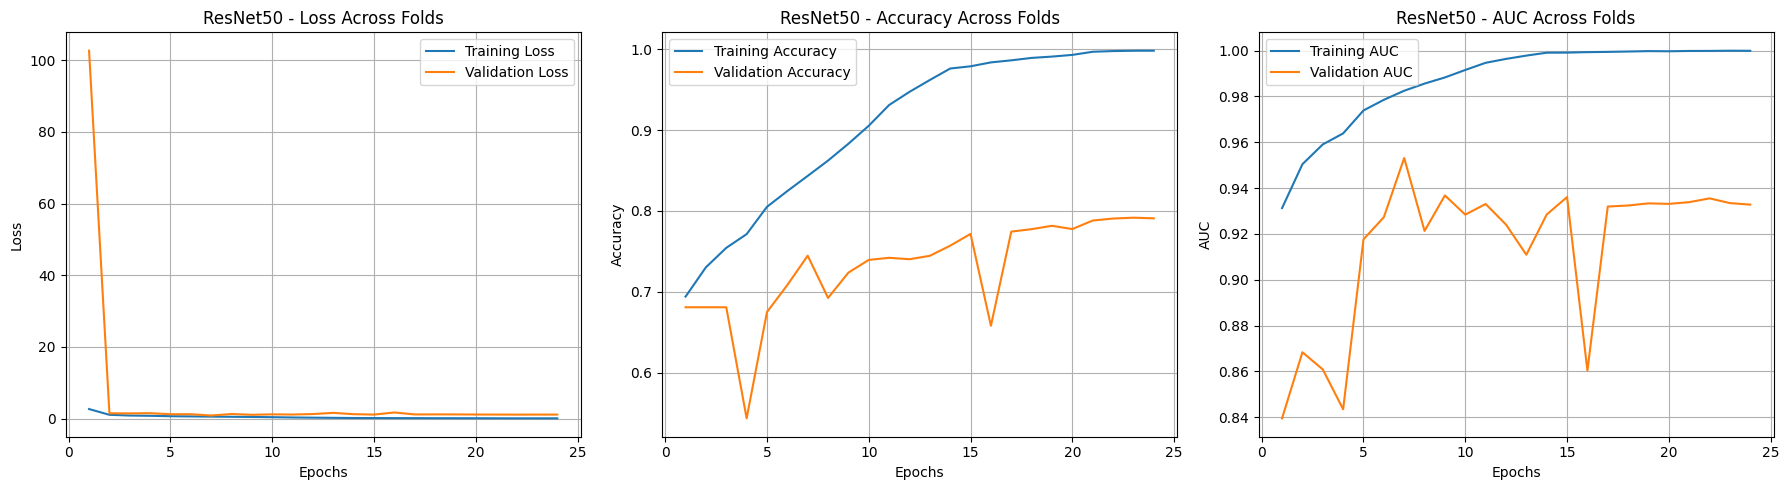


Starting 5-Fold CV for model: EfficientNetB3

--- Fold 1 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,639,606 (44.40 MB)

 Trainable params: 854,791 (3.26 MB)

 Non-trainable params: 10,784,815 (41.14 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 214s 816ms/step - accuracy: 0.2896 - auc: 0.6332 - loss: 2.8908 - val_accuracy: 0.7183 - val_auc: 0.9325 - val_loss: 0.8742 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 639ms/step - accuracy: 0.6036 - auc: 0.8591 - loss: 1.3550 - val_accuracy: 0.7295 - val_auc: 0.9470 - val_loss: 0.7858 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 639ms/step - accuracy: 0.6733 - auc: 0.9021 - loss: 1.0736 - val_accuracy: 0.7348 - val_auc: 0.9527 - val_loss: 0.7506 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 134s 634ms/step - accuracy: 0.6803 - auc: 0.9187 - loss: 0.9725 - val_accuracy: 0.7372 - val_auc: 0.9552 - val_loss: 0.7290 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 623ms/step - accuracy: 0.7056 - auc: 0.9318 - loss: 0.8872 - val_accuracy: 0.7401 - val_auc: 0.9574 - val_loss: 0.7159 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 130s 612ms/step - ac

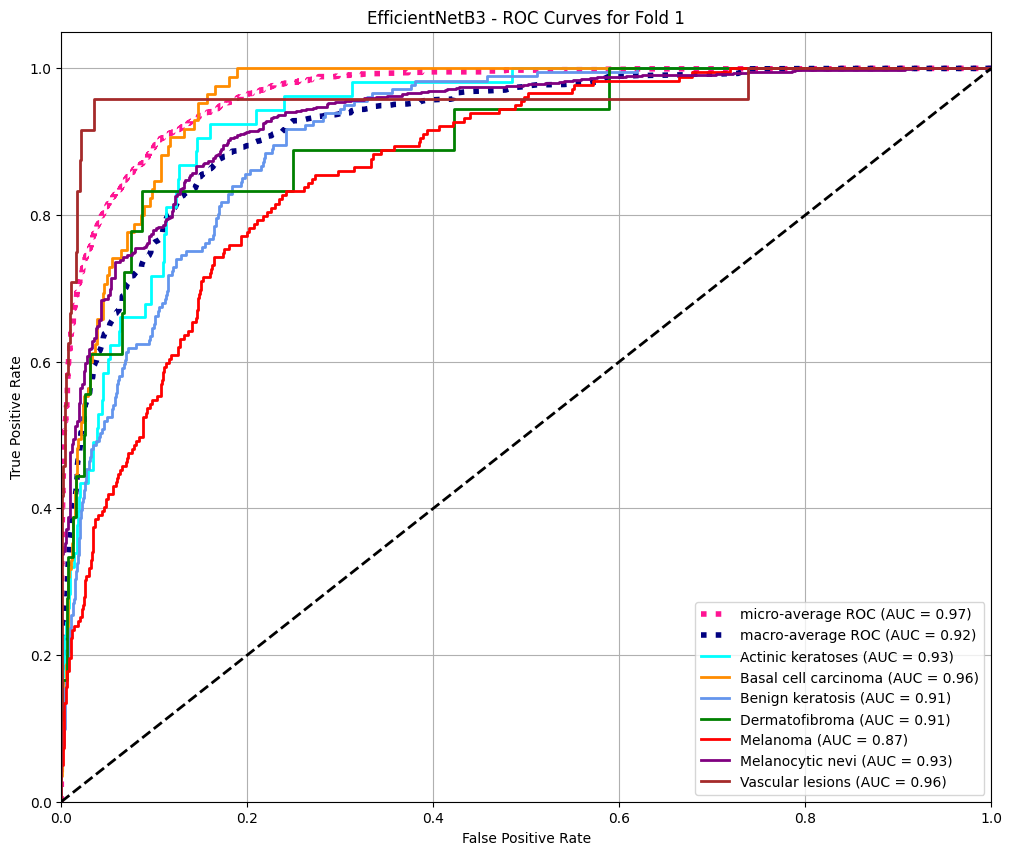


--- Fold 2 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 197s 770ms/step - accuracy: 0.3333 - auc: 0.6616 - loss: 2.7460 - val_accuracy: 0.7301 - val_auc: 0.9371 - val_loss: 0.8533 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 138s 650ms/step - accuracy: 0.6119 - auc: 0.8589 - loss: 1.3732 - val_accuracy: 0.7318 - val_auc: 0.9484 - val_loss: 0.7882 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 139s 656ms/step - accuracy: 0.6581 - auc: 0.9010 - loss: 1.0910 - val_accuracy: 0.7312 - val_auc: 0.9504 - val_loss: 0.7687 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 129s 607ms/step - accuracy: 0.6788 - auc: 0.9163 - loss: 0.9934 - val_accuracy: 0.7336 - val_auc: 0.9529 - val_loss: 0.7436 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 135s 635ms/step - accuracy: 0.7045 - auc: 0.9324 - loss: 0.8852 - val_accuracy: 0.7389 - val_auc: 0.9562 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 128s 605ms/step - ac

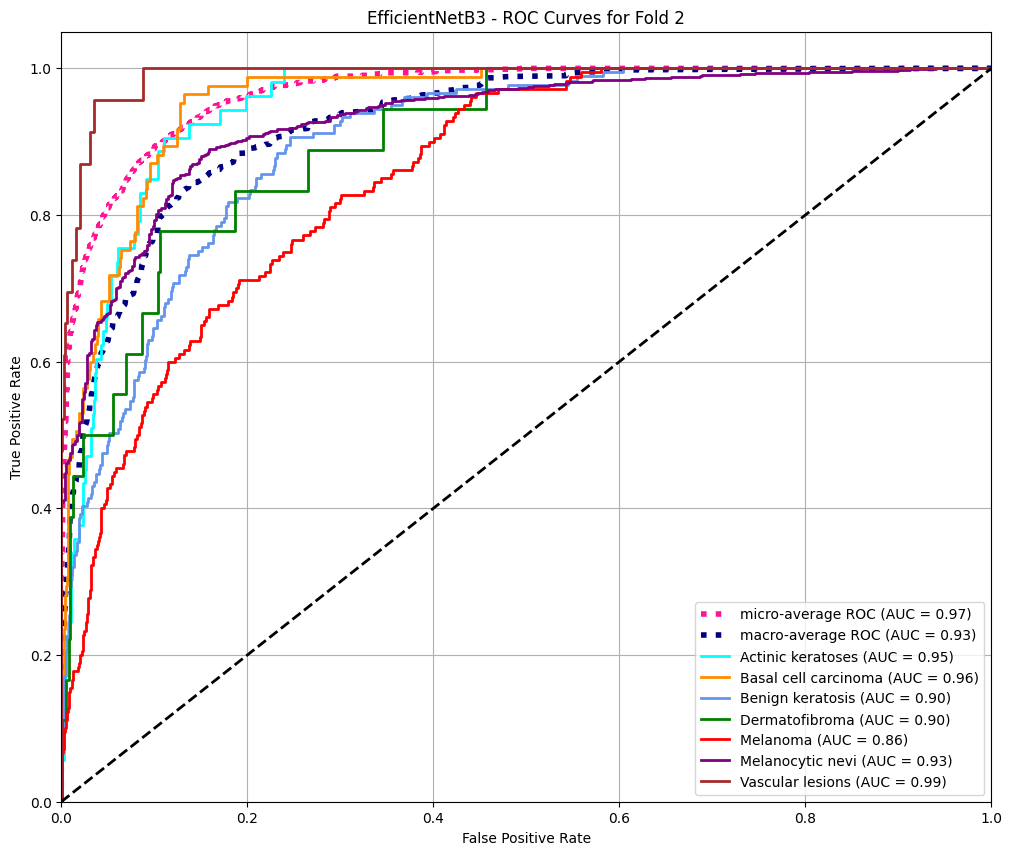


--- Fold 3 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 195s 761ms/step - accuracy: 0.3363 - auc: 0.6645 - loss: 2.6821 - val_accuracy: 0.7206 - val_auc: 0.9364 - val_loss: 0.8573 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 131s 619ms/step - accuracy: 0.6274 - auc: 0.8667 - loss: 1.3258 - val_accuracy: 0.7242 - val_auc: 0.9465 - val_loss: 0.7971 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 135s 638ms/step - accuracy: 0.6615 - auc: 0.9006 - loss: 1.0874 - val_accuracy: 0.7301 - val_auc: 0.9516 - val_loss: 0.7602 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 134s 630ms/step - accuracy: 0.6821 - auc: 0.9209 - loss: 0.9625 - val_accuracy: 0.7265 - val_auc: 0.9514 - val_loss: 0.7581 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 139s 657ms/step - accuracy: 0.6974 - auc: 0.9282 - loss: 0.9127 - val_accuracy: 0.7413 - val_auc: 0.9560 - val_loss: 0.7216 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 127s 598ms/step - ac

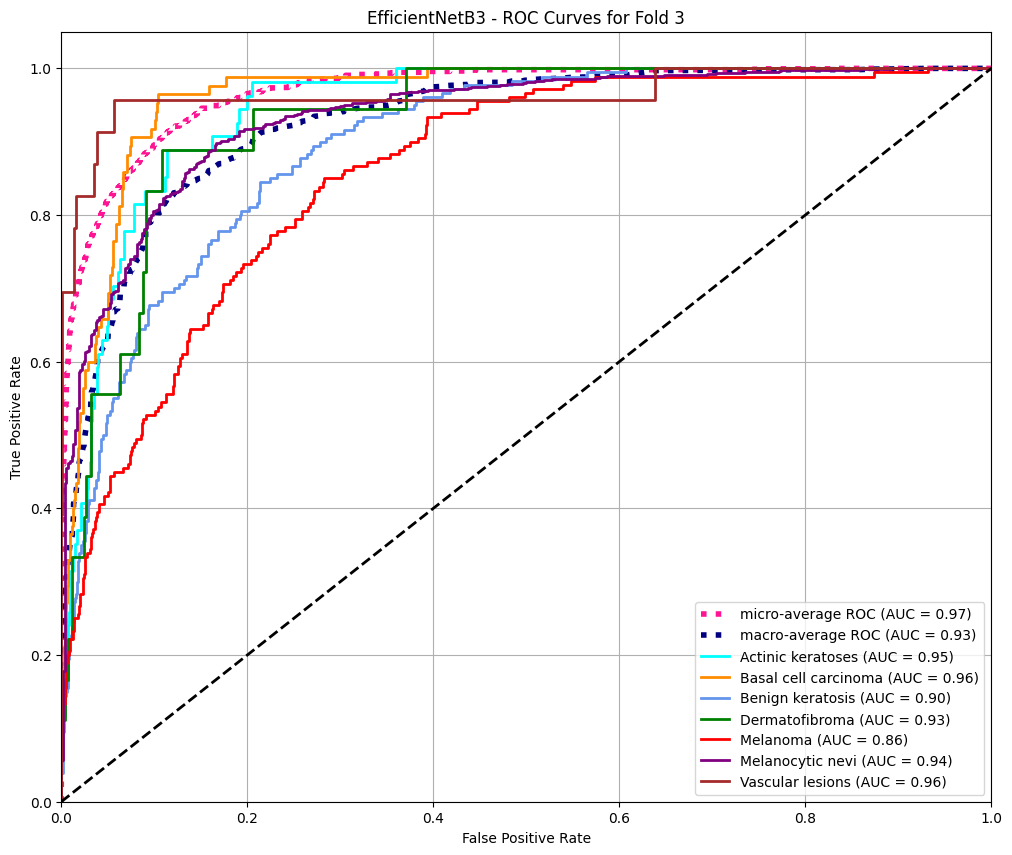


--- Fold 4 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 194s 754ms/step - accuracy: 0.3197 - auc: 0.6473 - loss: 2.7814 - val_accuracy: 0.7230 - val_auc: 0.9420 - val_loss: 0.8235 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 642ms/step - accuracy: 0.6093 - auc: 0.8656 - loss: 1.3363 - val_accuracy: 0.7377 - val_auc: 0.9522 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 137s 648ms/step - accuracy: 0.6601 - auc: 0.9003 - loss: 1.0884 - val_accuracy: 0.7413 - val_auc: 0.9546 - val_loss: 0.7364 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 129s 610ms/step - accuracy: 0.6841 - auc: 0.9218 - loss: 0.9541 - val_accuracy: 0.7507 - val_auc: 0.9569 - val_loss: 0.7180 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 134s 631ms/step - accuracy: 0.6976 - auc: 0.9312 - loss: 0.8987 - val_accuracy: 0.7496 - val_auc: 0.9586 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 131s 618ms/step - ac

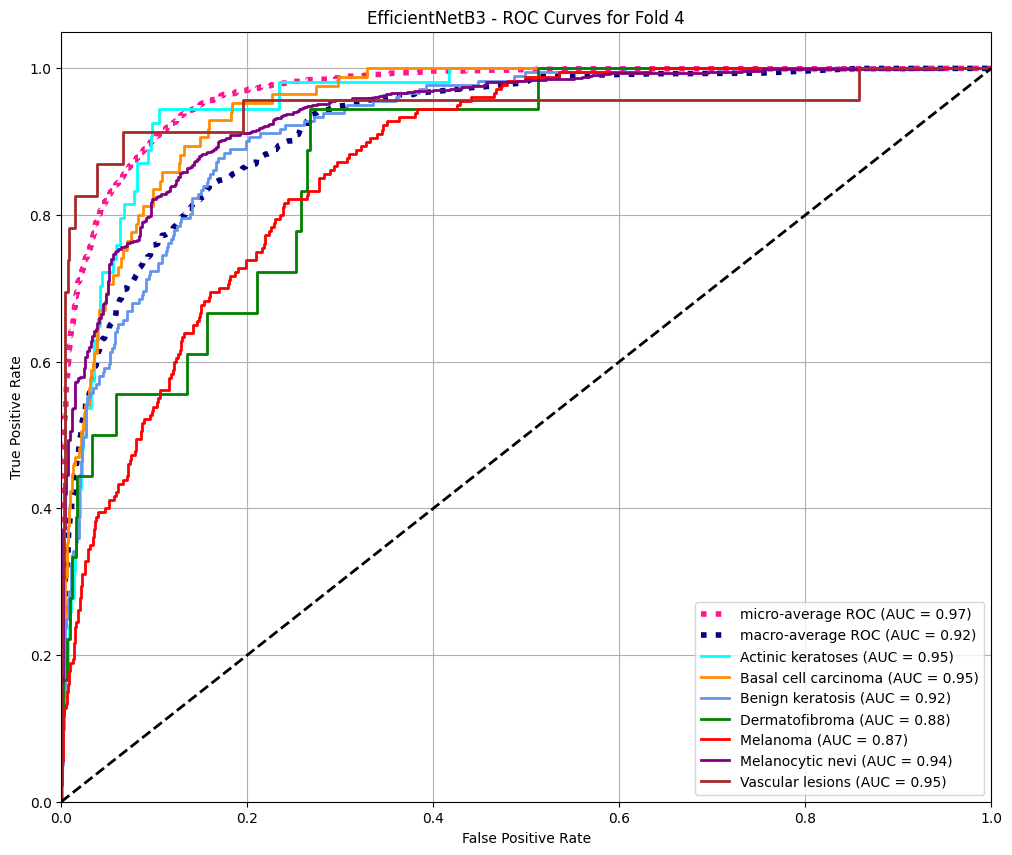


--- Fold 5 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6772 samples
Applying super-resolution to 6772 images...
Processing image 1/6772
Processing image 101/6772
Processing image 201/6772
Processing image 301/6772
Processing image 401/6772
Processing image 501/6772
Processing image 601/6772
Processing image 701/6772
Processing image 801/6772
Processing image 901/6772
Processing image 1001/6772
Processing image 1101/6772
Processing image 1201/6772
Processing image 1301/6772
Processing image 1401/6772
Processing image 1501/6772
Processing image 1601/6772
Processing image 1701/6772
Processing image 1801/6772
Processing image 1901/6772
Processing image 2001/6772
Processing image 2101/6772
Processing image 2201/6772
Processing image 2301/6772
Processing image 2401/6772
Processing image 2501/6772
Processing image 2601/6772
Processing image 2701/6772
Processing image 2801/6772
Processing image 2901/6772
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 206s 813ms/step - accuracy: 0.3145 - auc: 0.6430 - loss: 2.8510 - val_accuracy: 0.7104 - val_auc: 0.9251 - val_loss: 0.9156 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 132s 620ms/step - accuracy: 0.6009 - auc: 0.8585 - loss: 1.3985 - val_accuracy: 0.7281 - val_auc: 0.9430 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 133s 625ms/step - accuracy: 0.6721 - auc: 0.9040 - loss: 1.0697 - val_accuracy: 0.7400 - val_auc: 0.9505 - val_loss: 0.7677 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 133s 627ms/step - accuracy: 0.6796 - auc: 0.9174 - loss: 0.9851 - val_accuracy: 0.7376 - val_auc: 0.9546 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 130s 613ms/step - accuracy: 0.6964 - auc: 0.9305 - loss: 0.9002 - val_accuracy: 0.7400 - val_auc: 0.9576 - val_loss: 0.7185 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 129s 608ms/step - ac

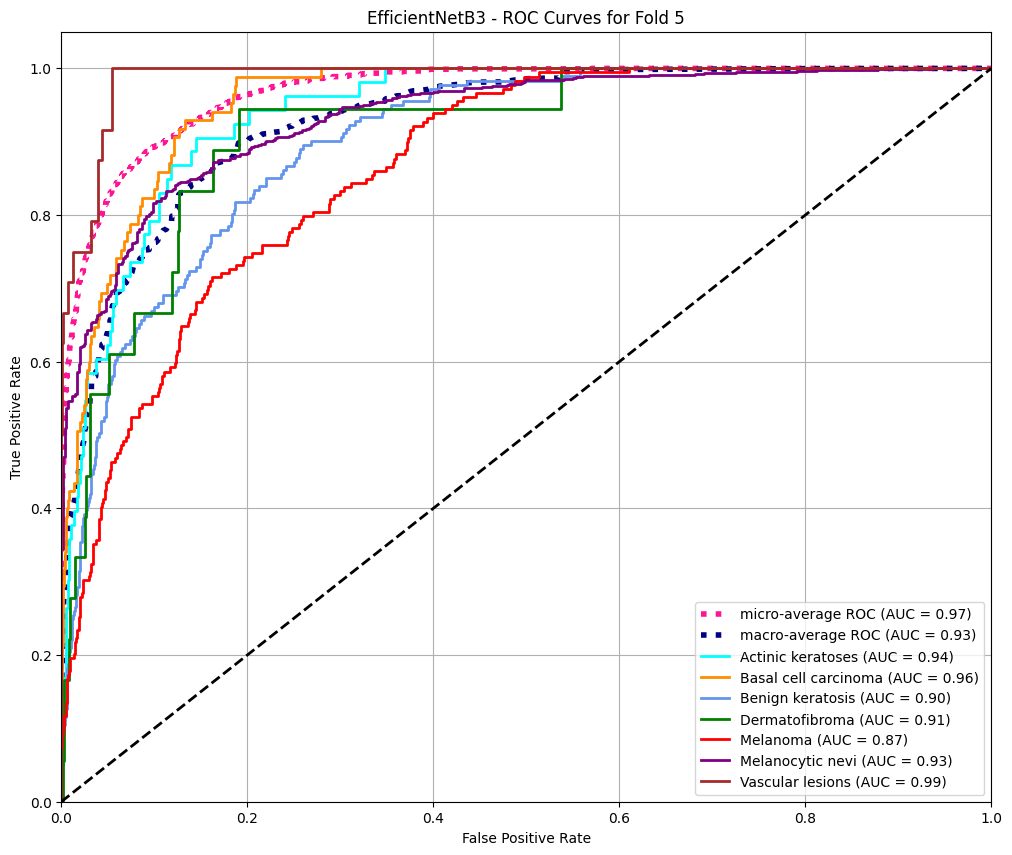


Model EfficientNetB3 - CV Validation Accuracies for each fold: [0.7743650078773499, 0.7690490484237671, 0.774955689907074, 0.7790903449058533, 0.7771867513656616]
Model EfficientNetB3 - Mean Validation Accuracy: 0.7749
Model EfficientNetB3 - CV Validation AUC for each fold: [0.9674444794654846, 0.9673987030982971, 0.9683294892311096, 0.9695145487785339, 0.9685051441192627]
Model EfficientNetB3 - Mean Validation AUC: 0.9682


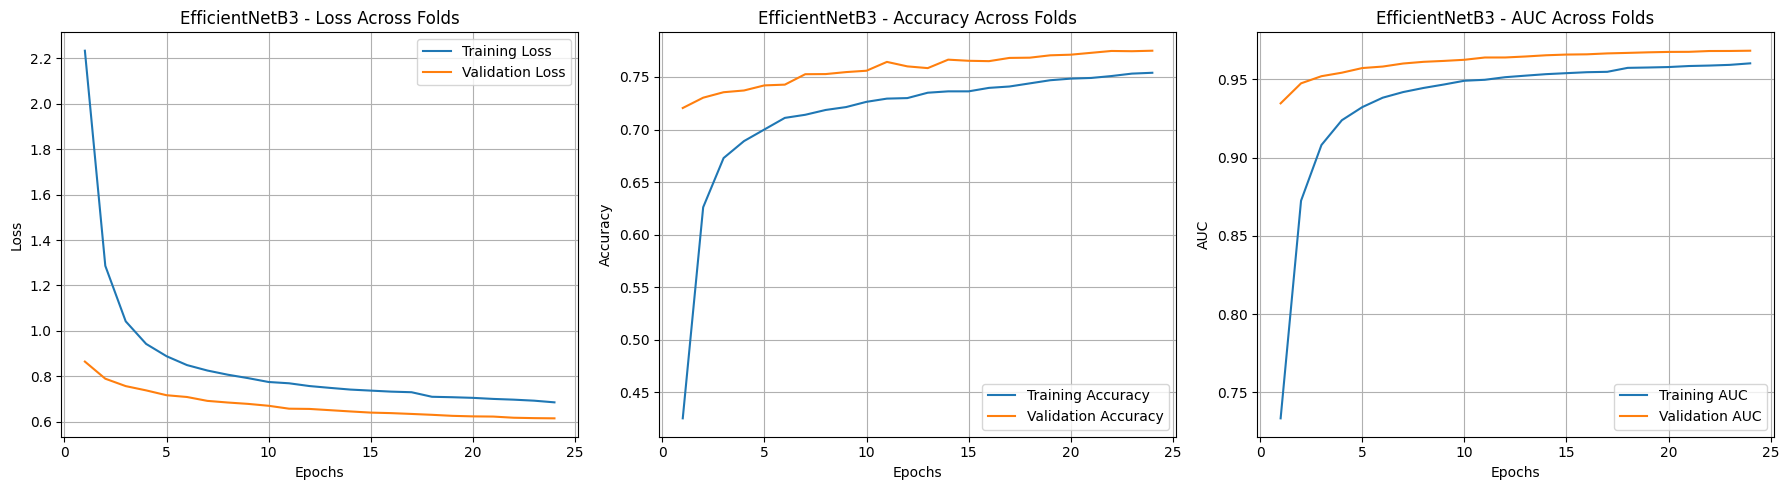


Starting 5-Fold CV for model: DenseNet201

--- Fold 1 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing im

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,374,663 (73.91 MB)

 Trainable params: 1,051,399 (4.01 MB)

 Non-trainable params: 18,323,264 (69.90 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 236s 886ms/step - accuracy: 0.2683 - auc: 0.6181 - loss: 2.9576 - val_accuracy: 0.6952 - val_auc: 0.9319 - val_loss: 0.8843 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 571ms/step - accuracy: 0.5849 - auc: 0.8477 - loss: 1.4180 - val_accuracy: 0.7289 - val_auc: 0.9440 - val_loss: 0.8072 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 124s 584ms/step - accuracy: 0.6710 - auc: 0.9020 - loss: 1.0795 - val_accuracy: 0.7312 - val_auc: 0.9495 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 127s 601ms/step - accuracy: 0.6858 - auc: 0.9187 - loss: 0.9709 - val_accuracy: 0.7301 - val_auc: 0.9518 - val_loss: 0.7558 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 120s 564ms/step - accuracy: 0.7046 - auc: 0.9312 - loss: 0.8943 - val_accuracy: 0.7324 - val_auc: 0.9520 - val_loss: 0.7520 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 125s 590ms/step - ac

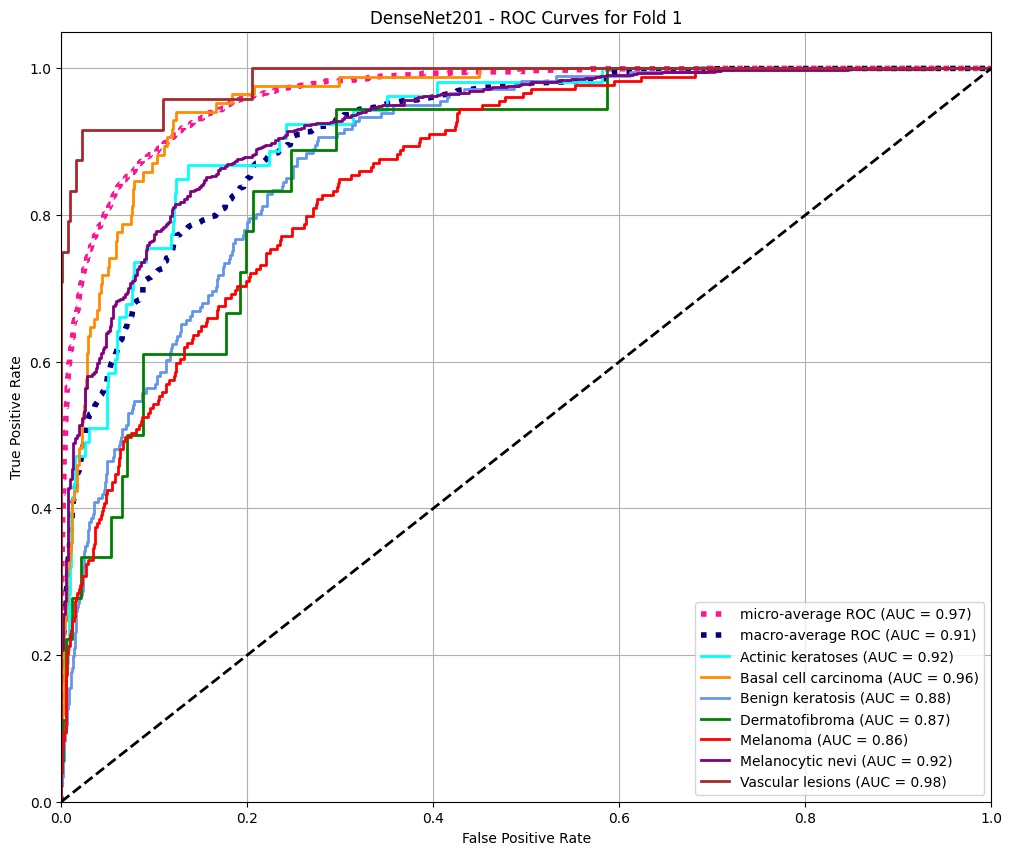


--- Fold 2 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 218s 836ms/step - accuracy: 0.2821 - auc: 0.6256 - loss: 2.8566 - val_accuracy: 0.7135 - val_auc: 0.9296 - val_loss: 0.9089 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 123s 580ms/step - accuracy: 0.5877 - auc: 0.8493 - loss: 1.4105 - val_accuracy: 0.7165 - val_auc: 0.9431 - val_loss: 0.8093 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 129s 609ms/step - accuracy: 0.6455 - auc: 0.8992 - loss: 1.1066 - val_accuracy: 0.7212 - val_auc: 0.9494 - val_loss: 0.7713 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 573ms/step - accuracy: 0.6816 - auc: 0.9193 - loss: 0.9686 - val_accuracy: 0.7295 - val_auc: 0.9532 - val_loss: 0.7475 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 125s 592ms/step - accuracy: 0.6852 - auc: 0.9298 - loss: 0.9127 - val_accuracy: 0.7295 - val_auc: 0.9543 - val_loss: 0.7341 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 129s 608ms/step - ac

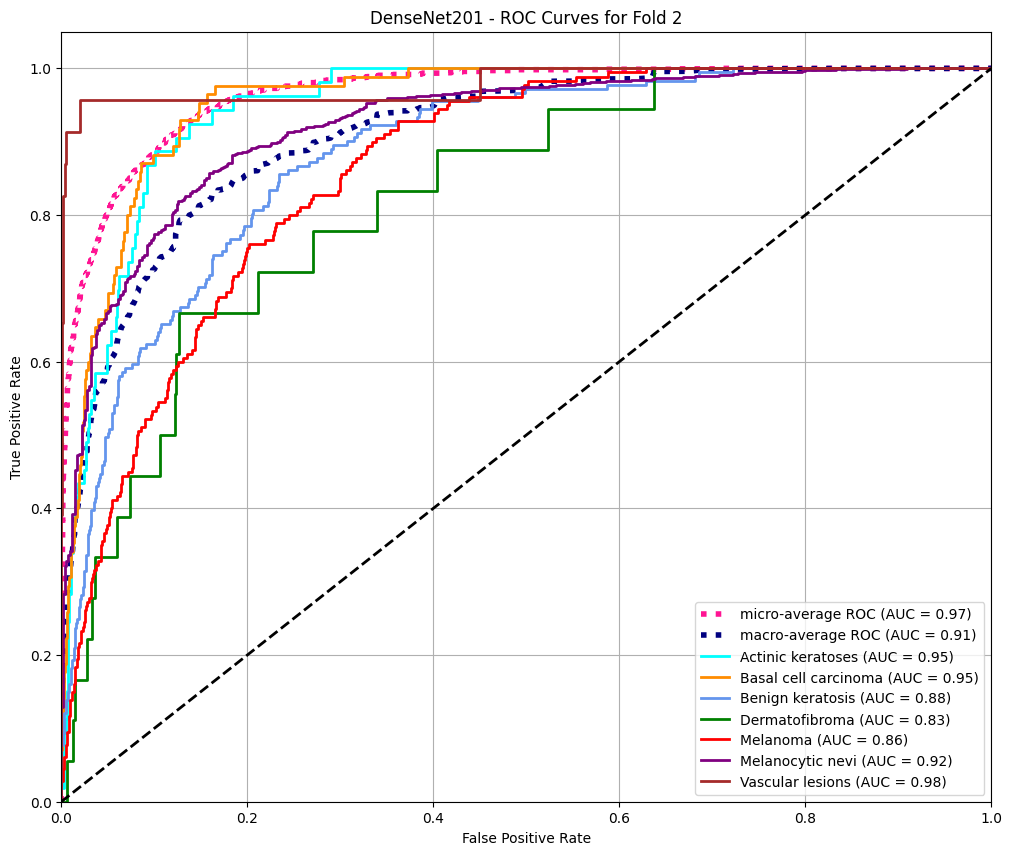


--- Fold 3 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 219s 839ms/step - accuracy: 0.3048 - auc: 0.6395 - loss: 2.8435 - val_accuracy: 0.7112 - val_auc: 0.9366 - val_loss: 0.8626 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 121s 570ms/step - accuracy: 0.5726 - auc: 0.8420 - loss: 1.4883 - val_accuracy: 0.7212 - val_auc: 0.9458 - val_loss: 0.8158 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 174s 822ms/step - accuracy: 0.6703 - auc: 0.9031 - loss: 1.0737 - val_accuracy: 0.7194 - val_auc: 0.9511 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 574ms/step - accuracy: 0.6861 - auc: 0.9159 - loss: 0.9889 - val_accuracy: 0.7283 - val_auc: 0.9545 - val_loss: 0.7451 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 128s 603ms/step - accuracy: 0.7053 - auc: 0.9295 - loss: 0.8986 - val_accuracy: 0.7330 - val_auc: 0.9564 - val_loss: 0.7274 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 128s 605ms/step - ac

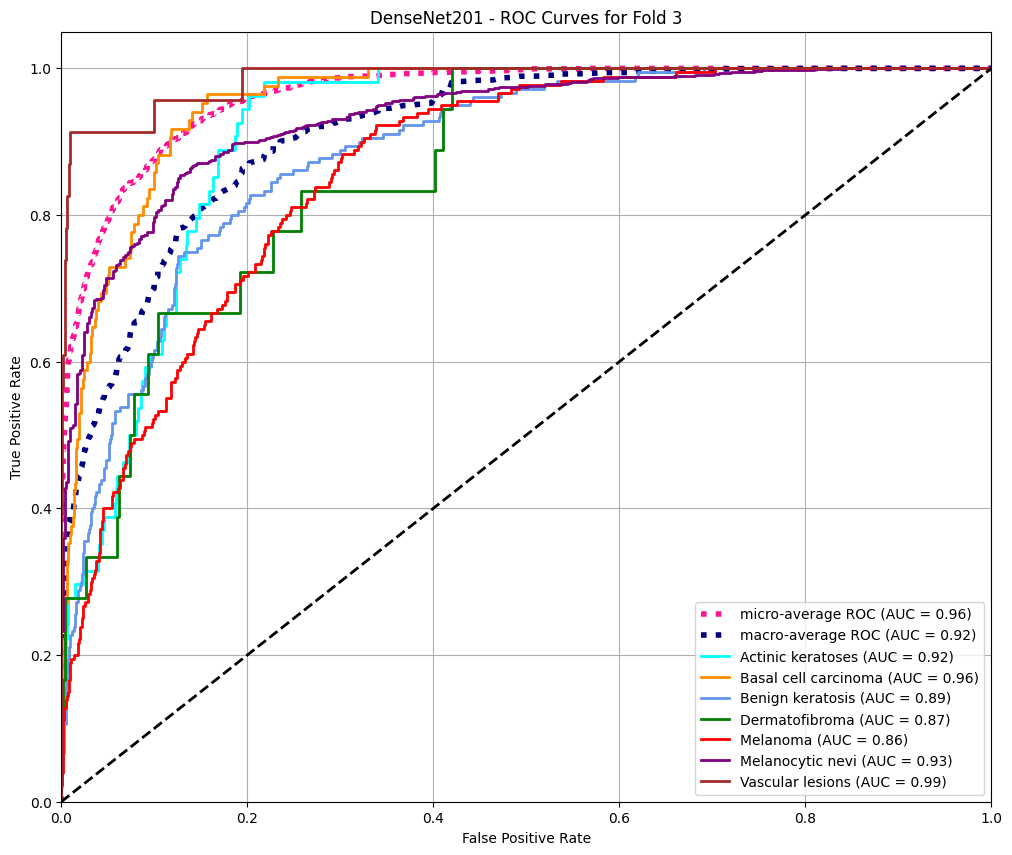


--- Fold 4 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6771 samples
Applying super-resolution to 6771 images...
Processing image 1/6771
Processing image 101/6771
Processing image 201/6771
Processing image 301/6771
Processing image 401/6771
Processing image 501/6771
Processing image 601/6771
Processing image 701/6771
Processing image 801/6771
Processing image 901/6771
Processing image 1001/6771
Processing image 1101/6771
Processing image 1201/6771
Processing image 1301/6771
Processing image 1401/6771
Processing image 1501/6771
Processing image 1601/6771
Processing image 1701/6771
Processing image 1801/6771
Processing image 1901/6771
Processing image 2001/6771
Processing image 2101/6771
Processing image 2201/6771
Processing image 2301/6771
Processing image 2401/6771
Processing image 2501/6771
Processing image 2601/6771
Processing image 2701/6771
Processing image 2801/6771
Processing image 2901/6771
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 215s 831ms/step - accuracy: 0.2952 - auc: 0.6367 - loss: 2.8020 - val_accuracy: 0.7177 - val_auc: 0.9355 - val_loss: 0.8626 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 128s 603ms/step - accuracy: 0.5903 - auc: 0.8460 - loss: 1.4540 - val_accuracy: 0.7230 - val_auc: 0.9468 - val_loss: 0.7926 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 124s 585ms/step - accuracy: 0.6579 - auc: 0.9000 - loss: 1.0908 - val_accuracy: 0.7212 - val_auc: 0.9503 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 120s 566ms/step - accuracy: 0.6734 - auc: 0.9147 - loss: 1.0025 - val_accuracy: 0.7307 - val_auc: 0.9532 - val_loss: 0.7487 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 125s 588ms/step - accuracy: 0.6897 - auc: 0.9275 - loss: 0.9175 - val_accuracy: 0.7289 - val_auc: 0.9557 - val_loss: 0.7310 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 120s 566ms/step - ac

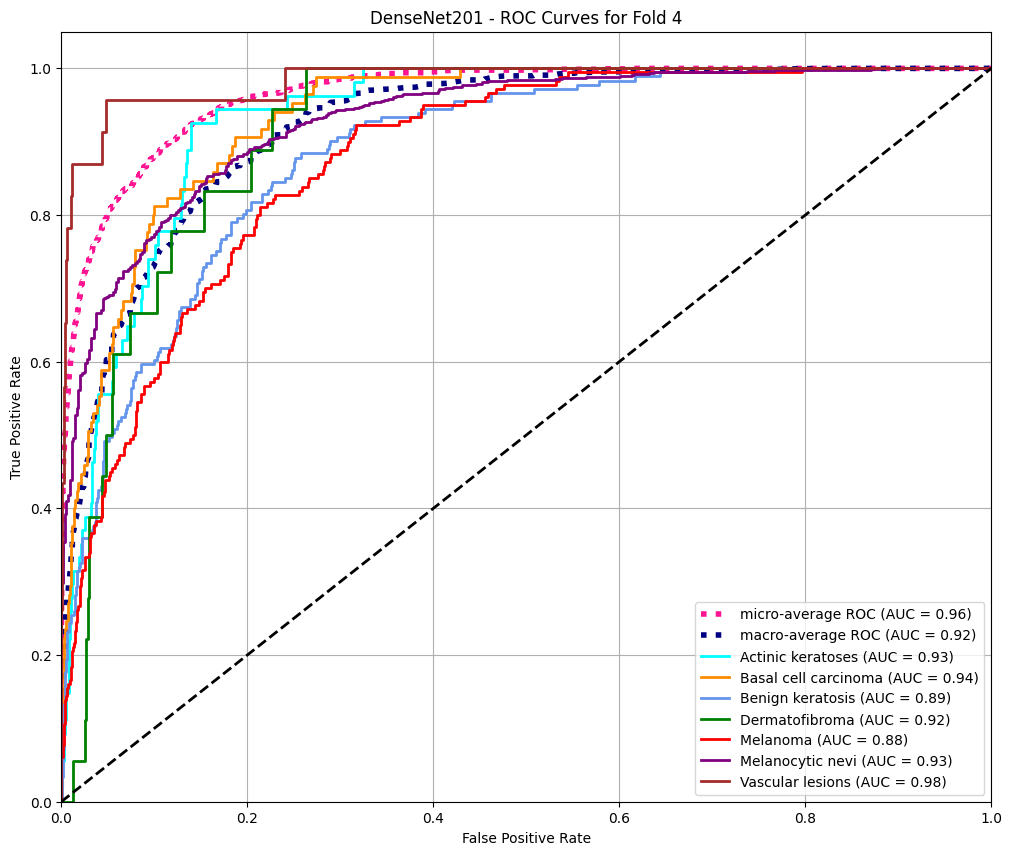


--- Fold 5 ---

Balancing training data...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced training set size: 6772 samples
Applying super-resolution to 6772 images...
Processing image 1/6772
Processing image 101/6772
Processing image 201/6772
Processing image 301/6772
Processing image 401/6772
Processing image 501/6772
Processing image 601/6772
Processing image 701/6772
Processing image 801/6772
Processing image 901/6772
Processing image 1001/6772
Processing image 1101/6772
Processing image 1201/6772
Processing image 1301/6772
Processing image 1401/6772
Processing image 1501/6772
Processing image 1601/6772
Processing image 1701/6772
Processing image 1801/6772
Processing image 1901/6772
Processing image 2001/6772
Processing image 2101/6772
Processing image 2201/6772
Processing image 2301/6772
Processing image 2401/6772
Processing image 2501/6772
Processing image 2601/6772
Processing image 2701/6772
Processing image 2801/6772
Processing image 2901/6772
Pr

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 228s 884ms/step - accuracy: 0.3024 - auc: 0.6426 - loss: 2.7665 - val_accuracy: 0.7021 - val_auc: 0.9327 - val_loss: 0.8821 - learning_rate: 0.0010
Epoch 2/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 126s 593ms/step - accuracy: 0.6007 - auc: 0.8534 - loss: 1.3752 - val_accuracy: 0.7193 - val_auc: 0.9440 - val_loss: 0.8202 - learning_rate: 0.0010
Epoch 3/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 129s 606ms/step - accuracy: 0.6451 - auc: 0.8938 - loss: 1.1281 - val_accuracy: 0.7270 - val_auc: 0.9510 - val_loss: 0.7659 - learning_rate: 0.0010
Epoch 4/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 127s 597ms/step - accuracy: 0.6782 - auc: 0.9189 - loss: 0.9761 - val_accuracy: 0.7305 - val_auc: 0.9525 - val_loss: 0.7547 - learning_rate: 0.0010
Epoch 5/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 126s 595ms/step - accuracy: 0.6930 - auc: 0.9245 - loss: 0.9369 - val_accuracy: 0.7275 - val_auc: 0.9545 - val_loss: 0.7404 - learning_rate: 0.0010
Epoch 6/24
212/212 ━━━━━━━━━━━━━━━━━━━━ 123s 580ms/step - ac

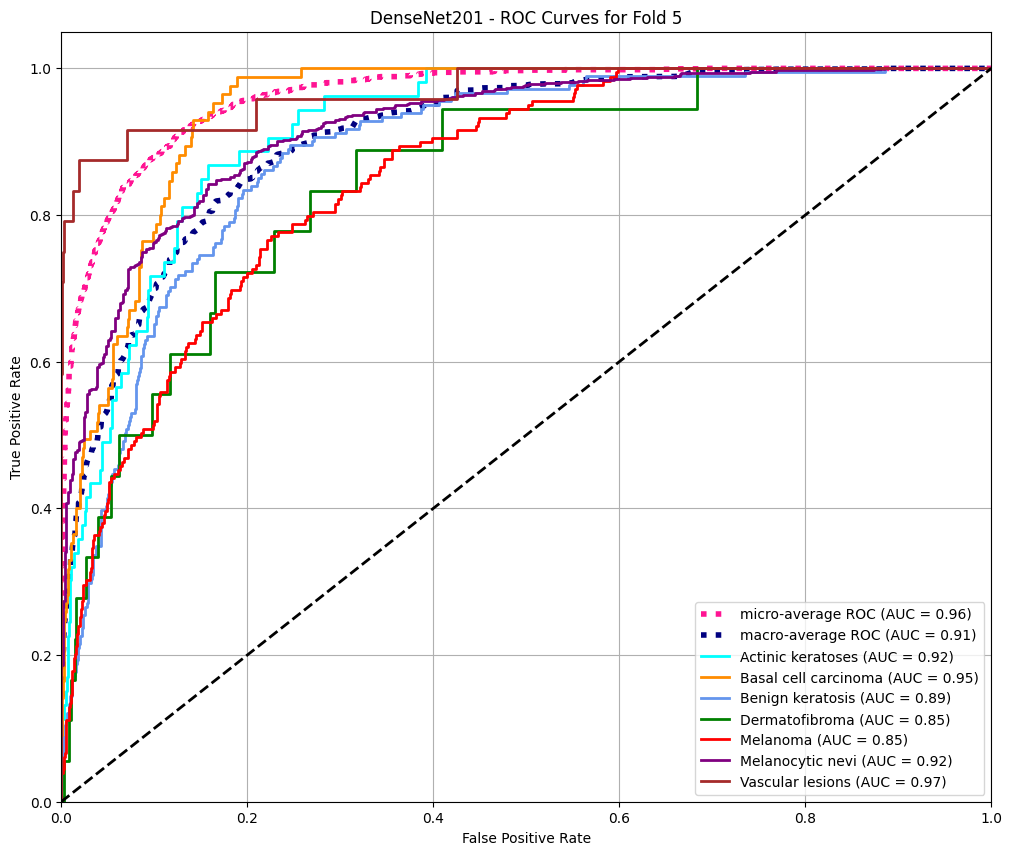


Model DenseNet201 - CV Validation Accuracies for each fold: [0.7708210349082947, 0.7613703608512878, 0.7607796788215637, 0.7590076923370361, 0.7529550790786743]
Model DenseNet201 - Mean Validation Accuracy: 0.7610
Model DenseNet201 - CV Validation AUC for each fold: [0.9646161794662476, 0.9652818441390991, 0.9638612866401672, 0.9644309282302856, 0.9630383253097534]
Model DenseNet201 - Mean Validation AUC: 0.9642


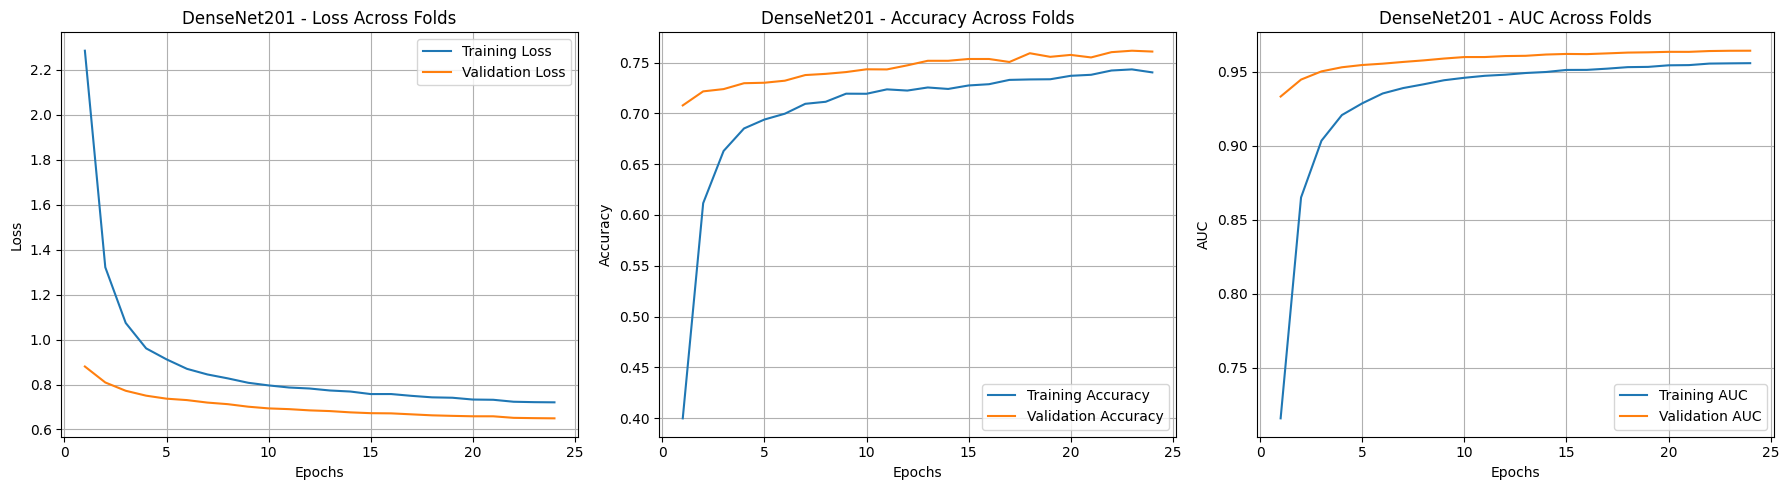

In [21]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
num_epochs = 24
batch_size = 32

for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Starting {num_folds}-Fold CV for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    fold_no = 1
    acc_per_fold = []
    loss_per_fold = []
    auc_per_fold = []
    val_loss_histories = []
    val_acc_histories = []
    val_auc_histories = []
    train_loss_histories = []
    train_acc_histories = []
    train_auc_histories = []

    roc_curves = {'fold': [], 'fpr': [], 'tpr': [], 'roc_auc': []}

    for train_index, val_index in skf.split(df_train, df_train['label_numeric']):
        print(f"\n--- Fold {fold_no} ---")
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        print("\nBalancing training data...")
        balanced_train_data = balance_data(train_data, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
        print(f"Final balanced training set size: {len(balanced_train_data)} samples")

        if use_rescale:
            train_gen_fold = tr_gen_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )
        else:
            train_gen_fold = tr_gen_no_rescale.flow_from_dataframe(
                balanced_train_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=True,
                batch_size=batch_size
            )
            valid_gen_fold = ts_gen_no_rescale.flow_from_dataframe(
                val_data,
                x_col='path',
                y_col='label',
                target_size=img_size,
                class_mode='categorical',
                color_mode='rgb',
                shuffle=False,
                batch_size=batch_size
            )

        class_indices = train_gen_fold.class_indices
        class_names = list(class_indices.keys())

        model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=len(class_indices))
        model = compile_model(model)

        if fold_no == 1:
            model.summary()

        history = model.fit(
            train_gen_fold,
            epochs=num_epochs,
            validation_data=valid_gen_fold,
            callbacks=[learning_rate_reduction],
            verbose=1
        )

        train_loss_histories.append(history.history['loss'])
        train_acc_histories.append(history.history['accuracy'])
        train_auc_histories.append(history.history['auc'])
        val_loss_histories.append(history.history['val_loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_auc_histories.append(history.history['val_auc'])

        fold_val_loss, fold_val_acc, fold_val_auc = model.evaluate(valid_gen_fold)
        print(f"Fold {fold_no} - Validation Loss: {fold_val_loss:.4f}, Validation Accuracy: {fold_val_acc:.4f}, Validation AUC: {fold_val_auc:.4f}")

        loss_per_fold.append(fold_val_loss)
        acc_per_fold.append(fold_val_acc)
        auc_per_fold.append(fold_val_auc)

        y_pred = model.predict(valid_gen_fold)
        y_true = np.array(valid_gen_fold.classes)
        class_names = list(valid_gen_fold.class_indices.keys())

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(len(class_indices)):
            y_true_binary = np.array(y_true == i, dtype=int)
            fpr[i], tpr[i], _ = roc_curve(
                y_true_binary,
                y_pred[:, i]
            )
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(
            tf.keras.utils.to_categorical(y_true, num_classes=len(class_indices)).ravel(),
            y_pred.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_indices))]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(class_indices)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(class_indices)
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        roc_curves['fold'].append(fold_no)
        roc_curves['fpr'].append(fpr)
        roc_curves['tpr'].append(tpr)
        roc_curves['roc_auc'].append(roc_auc)

        lesion_names = [lesion_type_dict[key] for key in class_names]
        plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - ROC Curves for Fold {fold_no}")

        del model
        tf.keras.backend.clear_session()
        gc.collect()

        fold_no += 1

    print(f"\nModel {model_name} - CV Validation Accuracies for each fold: {acc_per_fold}")
    print(f"Model {model_name} - Mean Validation Accuracy: {np.mean(acc_per_fold):.4f}")
    print(f"Model {model_name} - CV Validation AUC for each fold: {auc_per_fold}")
    print(f"Model {model_name} - Mean Validation AUC: {np.mean(auc_per_fold):.4f}")

    avg_train_loss = np.mean(np.array(train_loss_histories), axis=0)
    avg_train_accuracy = np.mean(np.array(train_acc_histories), axis=0)
    avg_train_auc = np.mean(np.array(train_auc_histories), axis=0)
    avg_val_loss = np.mean(np.array(val_loss_histories), axis=0)
    avg_val_accuracy = np.mean(np.array(val_acc_histories), axis=0)
    avg_val_auc = np.mean(np.array(val_auc_histories), axis=0)
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, avg_train_loss, label='Training Loss')
    plt.plot(epochs_range, avg_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, avg_train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, avg_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy Across Folds')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, avg_train_auc, label='Training AUC')
    plt.plot(epochs_range, avg_val_auc, label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{model_name} - AUC Across Folds')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Final Training and Evaluation


Final Training and Evaluation for model: ResNet50

Balancing full training data for final model...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced full training set size: 8464 samples
Applying super-resolution to 8464 images...
Processing image 1/8464
Processing image 101/8464
Processing image 201/8464
Processing image 301/8464
Processing image 401/8464
Processing image 501/8464
Processing image 601/8464
Processing image 701/8464
Processing image 801/8464
Processing image 901/8464
Processing image 1001/8464
Processing image 1101/8464
Processing image 1201/8464
Processing image 1301/8464
Processing image 1401/8464
Processing image 1501/8464
Processing image 1601/8464
Processing image 1701/8464
Processing image 1801/8464
Processing image 1901/8464
Processing image 2001/8464
Processing image 2101/8464
Processing image 2201/8464
Processing image 2301/8464
Processing image 2401/8464
Processing image 2501/8464
Processing image 2601/8464
Processing image 2701/

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 213s 594ms/step - accuracy: 0.6785 - auc: 0.9190 - loss: 3.7264 - learning_rate: 0.0010
Epoch 2/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 139s 526ms/step - accuracy: 0.7260 - auc: 0.9516 - loss: 1.0268 - learning_rate: 0.0010
Epoch 3/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 134s 506ms/step - accuracy: 0.7549 - auc: 0.9617 - loss: 0.8094 - learning_rate: 0.0010
Epoch 4/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 138s 521ms/step - accuracy: 0.7949 - auc: 0.9699 - loss: 0.7072 - learning_rate: 0.0010
Epoch 5/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 145s 546ms/step - accuracy: 0.7863 - auc: 0.9713 - loss: 0.6842 - learning_rate: 0.0010
Epoch 6/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 137s 516ms/step - accuracy: 0.8096 - auc: 0.9747 - loss: 0.6400 - learning_rate: 0.0010
Epoch 7/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 142s 536ms/step - accuracy: 0.8285 - auc: 0.9787 - loss: 0.5951 - learning_rate: 0.0010
Epoch 8/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 134s 503ms/step - accuracy: 0.8455 - auc: 0.9818 - loss: 0.5545 

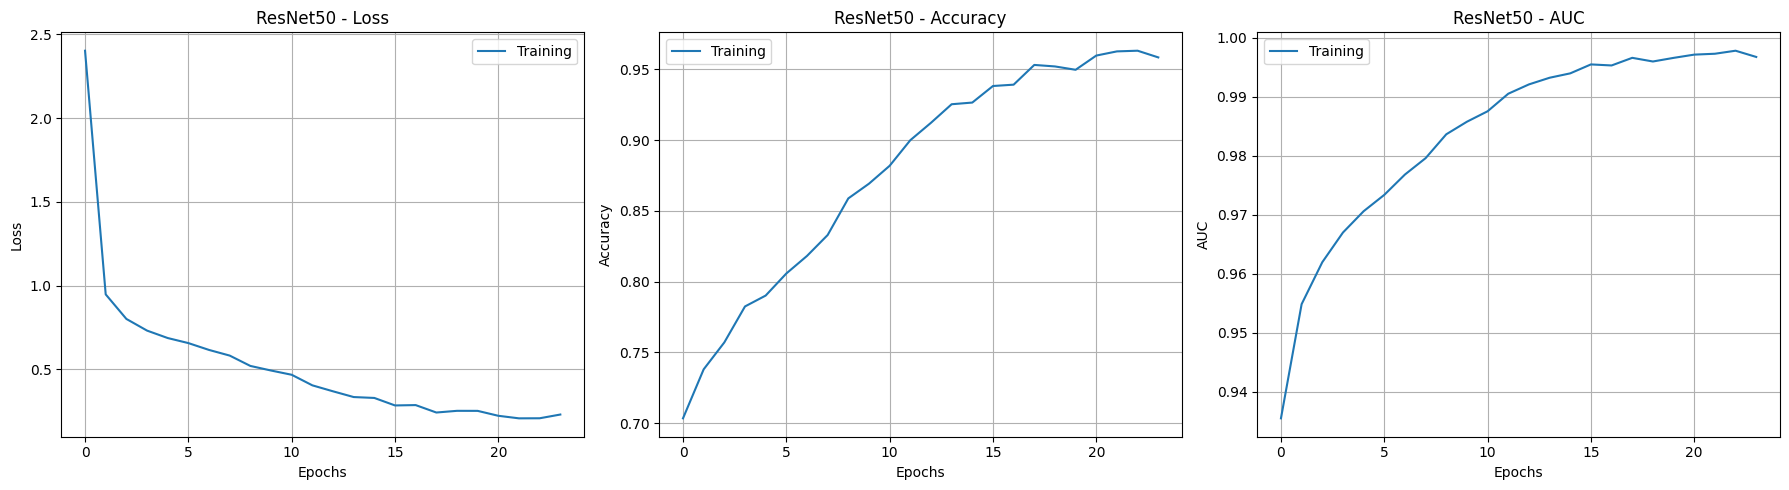


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 320ms/step - accuracy: 0.5415 - auc: 0.8298 - loss: 2.1890

Test Loss for ResNet50: 2.2079
Test Accuracy for ResNet50: 0.5434
Test AUC for ResNet50: 0.8266

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 302ms/step


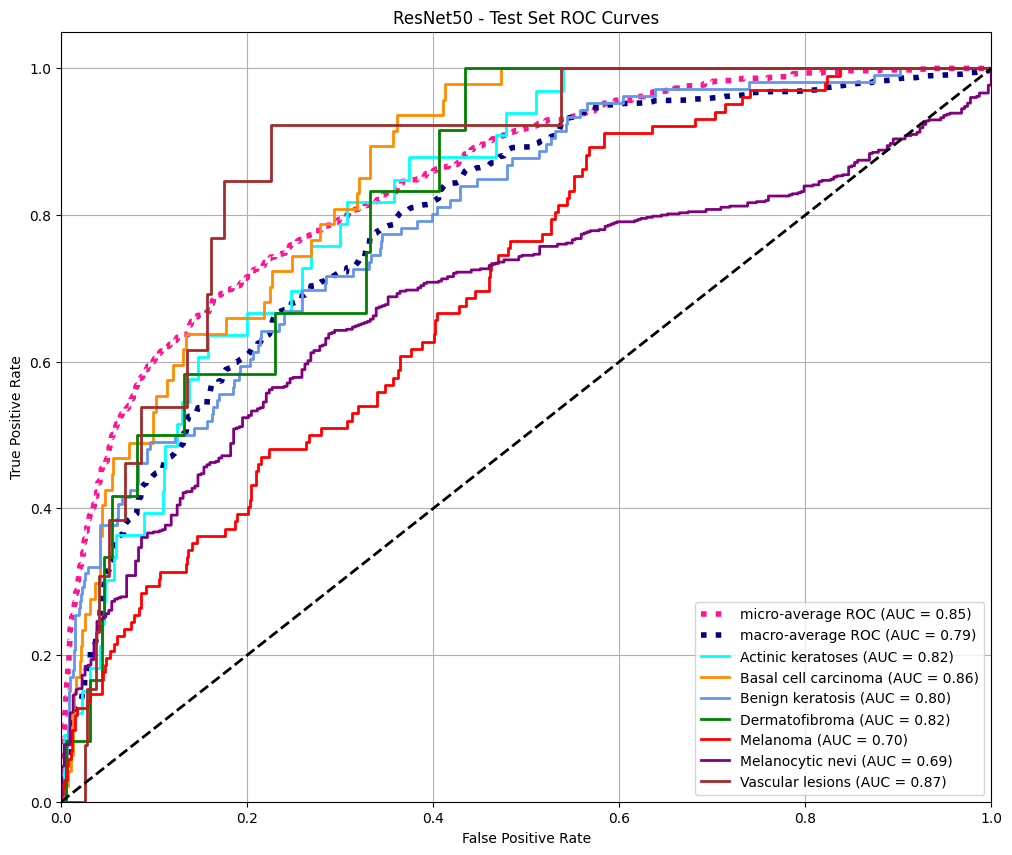


Generating confusion matrix...


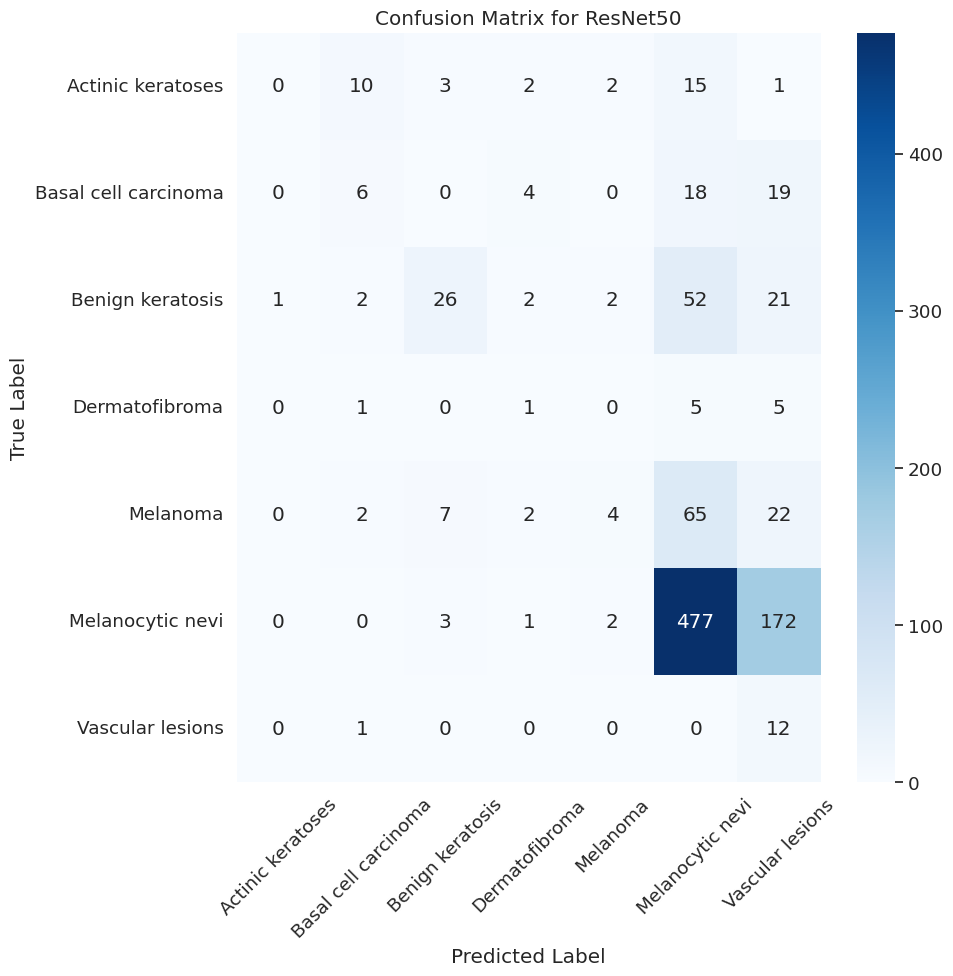


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.00      0.00      0.00        33
Basal cell carcinoma       0.27      0.13      0.17        47
    Benign keratosis       0.67      0.25      0.36       106
      Dermatofibroma       0.08      0.08      0.08        12
            Melanoma       0.40      0.04      0.07       102
    Melanocytic nevi       0.75      0.73      0.74       655
    Vascular lesions       0.05      0.92      0.09        13

            accuracy                           0.54       968
           macro avg       0.32      0.31      0.22       968
        weighted avg       0.64      0.54      0.56       968


Final Training and Evaluation for model: EfficientNetB3

Balancing full training data for final model...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced full training set size: 8464 samples
Applying super-resolution to 8464 images...
Processing image 1/8464


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 197s 612ms/step - accuracy: 0.3350 - auc: 0.6666 - loss: 2.6474 - learning_rate: 0.0010
Epoch 2/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 151s 568ms/step - accuracy: 0.6346 - auc: 0.8769 - loss: 1.2398 - learning_rate: 0.0010
Epoch 3/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 148s 558ms/step - accuracy: 0.6807 - auc: 0.9105 - loss: 1.0187 - learning_rate: 0.0010
Epoch 4/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 159s 599ms/step - accuracy: 0.6959 - auc: 0.9292 - loss: 0.9086 - learning_rate: 0.0010
Epoch 5/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 152s 571ms/step - accuracy: 0.7009 - auc: 0.9358 - loss: 0.8651 - learning_rate: 0.0010
Epoch 6/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 151s 570ms/step - accuracy: 0.7070 - auc: 0.9413 - loss: 0.8319 - learning_rate: 0.0010
Epoch 7/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 152s 574ms/step - accuracy: 0.7162 - auc: 0.9445 - loss: 0.8062 - learning_rate: 0.0010
Epoch 8/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 144s 545ms/step - accuracy: 0.7245 - auc: 0.9486 - loss: 0.7782 

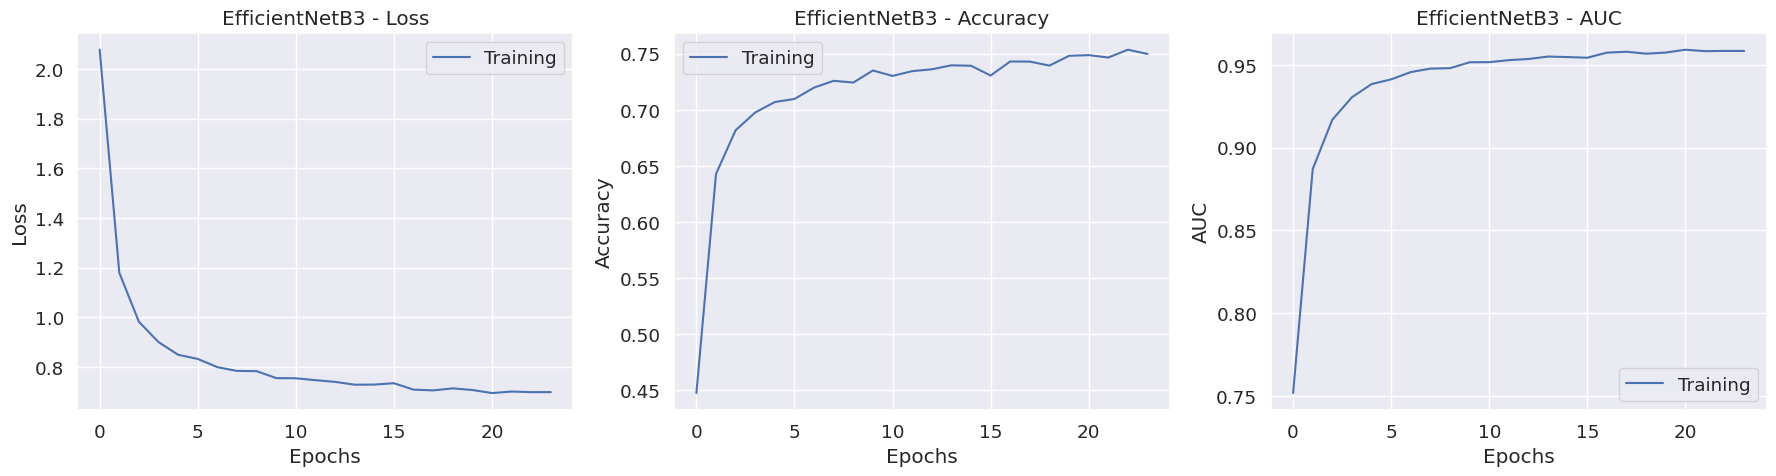


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 498ms/step - accuracy: 0.7565 - auc: 0.9625 - loss: 0.6604

Test Loss for EfficientNetB3: 0.6947
Test Accuracy for EfficientNetB3: 0.7376
Test AUC for EfficientNetB3: 0.9587

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step


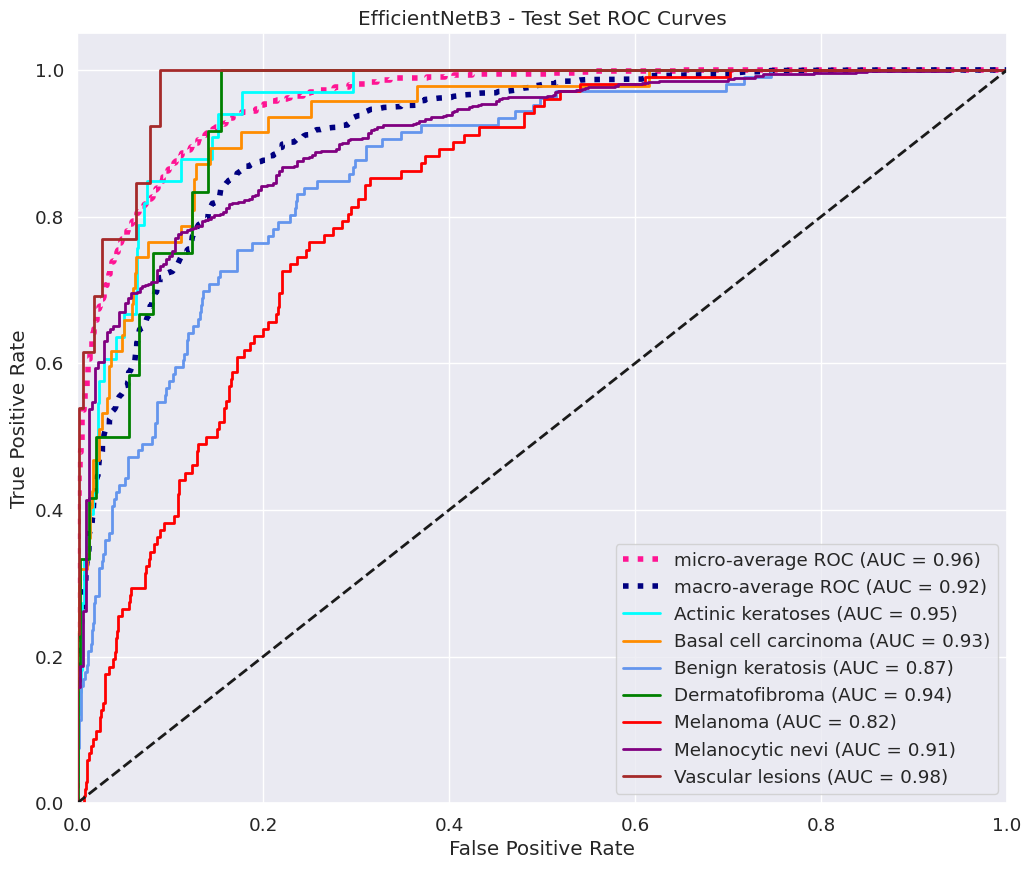


Generating confusion matrix...


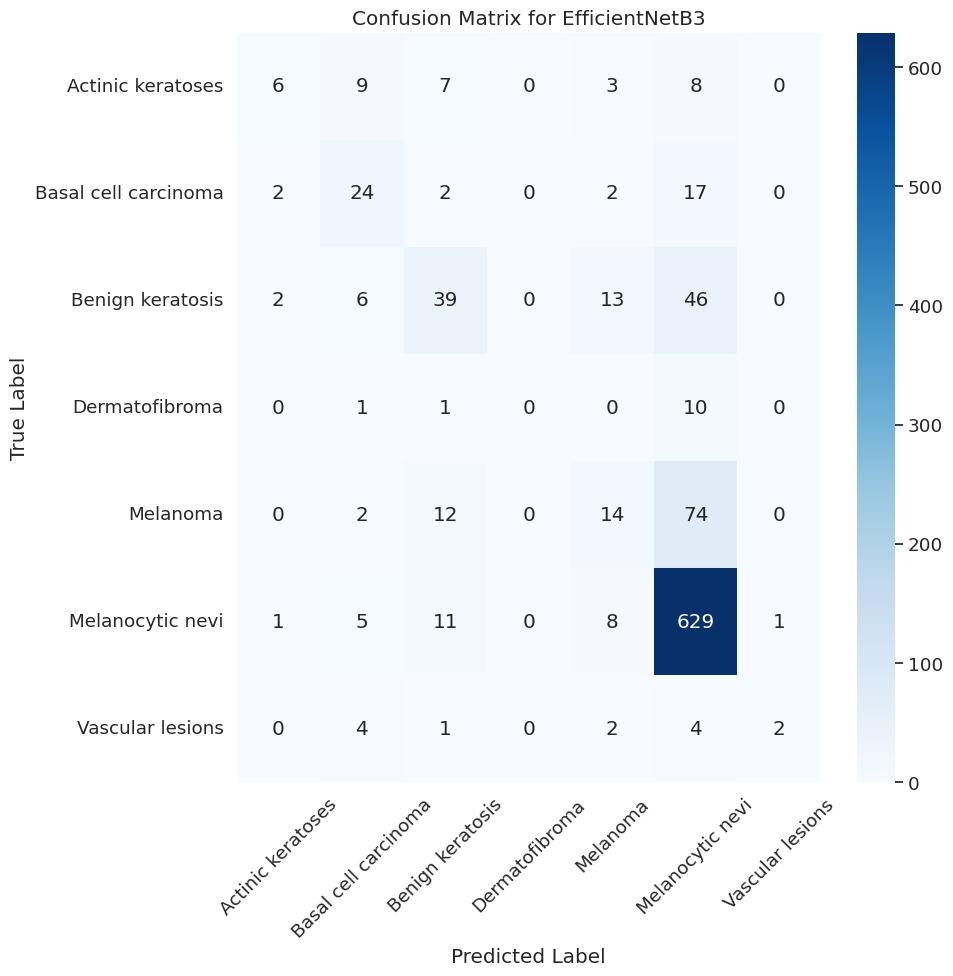


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.55      0.18      0.27        33
Basal cell carcinoma       0.47      0.51      0.49        47
    Benign keratosis       0.53      0.37      0.44       106
      Dermatofibroma       0.00      0.00      0.00        12
            Melanoma       0.33      0.14      0.19       102
    Melanocytic nevi       0.80      0.96      0.87       655
    Vascular lesions       0.67      0.15      0.25        13

            accuracy                           0.74       968
           macro avg       0.48      0.33      0.36       968
        weighted avg       0.68      0.74      0.69       968


Final Training and Evaluation for model: DenseNet201

Balancing full training data for final model...
Skipping oversampling as USE_AUGMENTATION_AND_OVERSAMPLING=False
Final balanced full training set size: 8464 samples
Applying super-resolution to 8464 images...
Processing image 1/8464
Pro

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 203s 617ms/step - accuracy: 0.3126 - auc: 0.6535 - loss: 2.7278 - learning_rate: 0.0010
Epoch 2/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 147s 554ms/step - accuracy: 0.6233 - auc: 0.8656 - loss: 1.3260 - learning_rate: 0.0010
Epoch 3/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 165s 621ms/step - accuracy: 0.6733 - auc: 0.9116 - loss: 1.0249 - learning_rate: 0.0010
Epoch 4/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 144s 543ms/step - accuracy: 0.6882 - auc: 0.9261 - loss: 0.9267 - learning_rate: 0.0010
Epoch 5/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 138s 519ms/step - accuracy: 0.7012 - auc: 0.9327 - loss: 0.8846 - learning_rate: 0.0010
Epoch 6/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 149s 561ms/step - accuracy: 0.6974 - auc: 0.9384 - loss: 0.8516 - learning_rate: 0.0010
Epoch 7/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 150s 564ms/step - accuracy: 0.7219 - auc: 0.9455 - loss: 0.8000 - learning_rate: 0.0010
Epoch 8/24
265/265 ━━━━━━━━━━━━━━━━━━━━ 144s 543ms/step - accuracy: 0.7093 - auc: 0.9426 - loss: 0.8197 

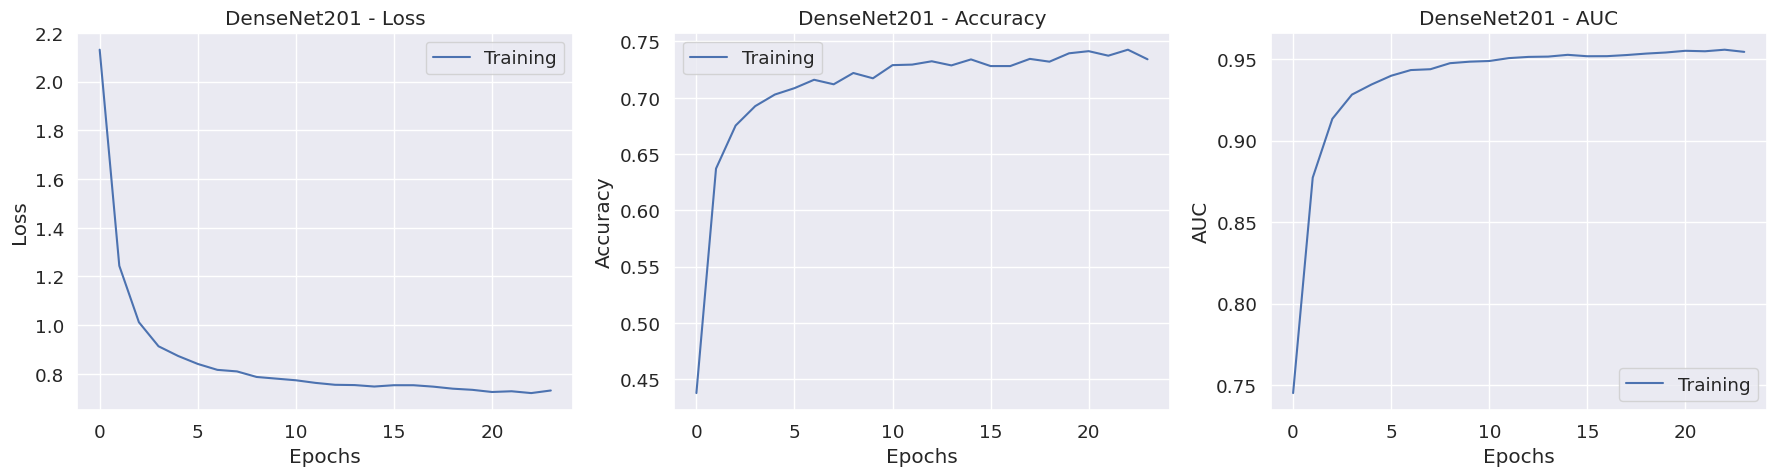


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 825ms/step - accuracy: 0.7623 - auc: 0.9595 - loss: 0.6839

Test Loss for DenseNet201: 0.6908
Test Accuracy for DenseNet201: 0.7469
Test AUC for DenseNet201: 0.9593

Generating predictions for ROC curves...
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 849ms/step


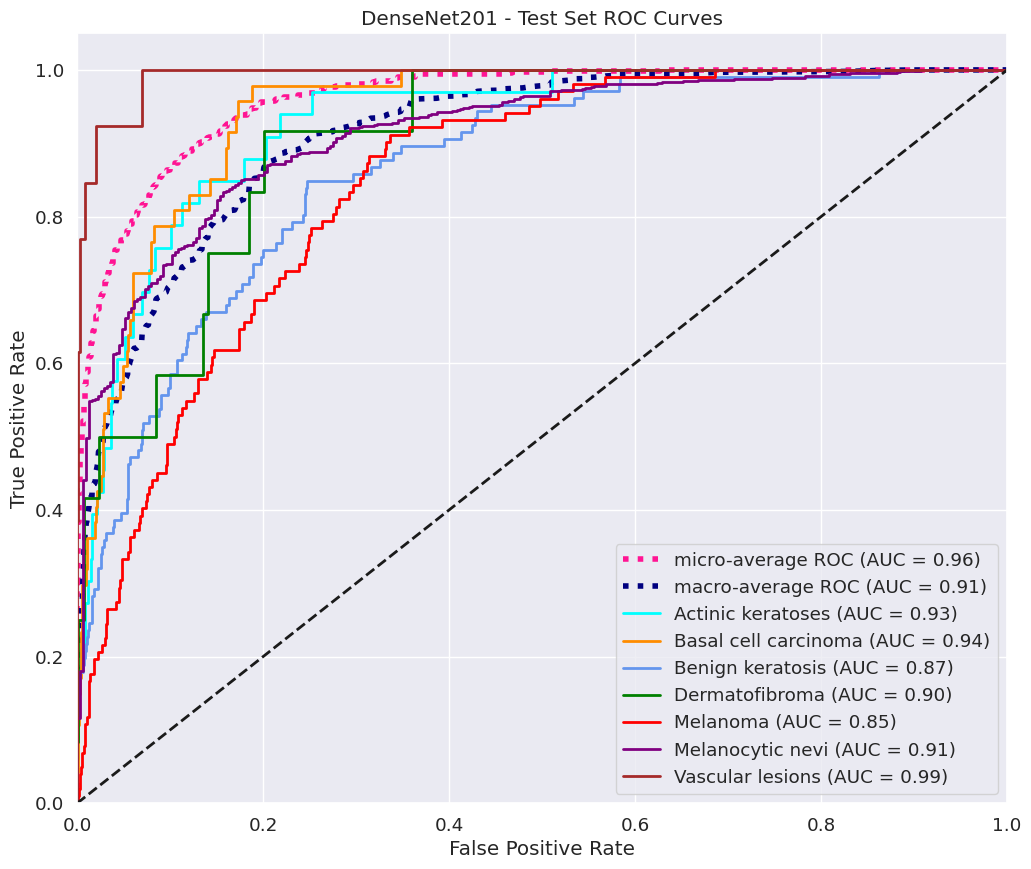


Generating confusion matrix...


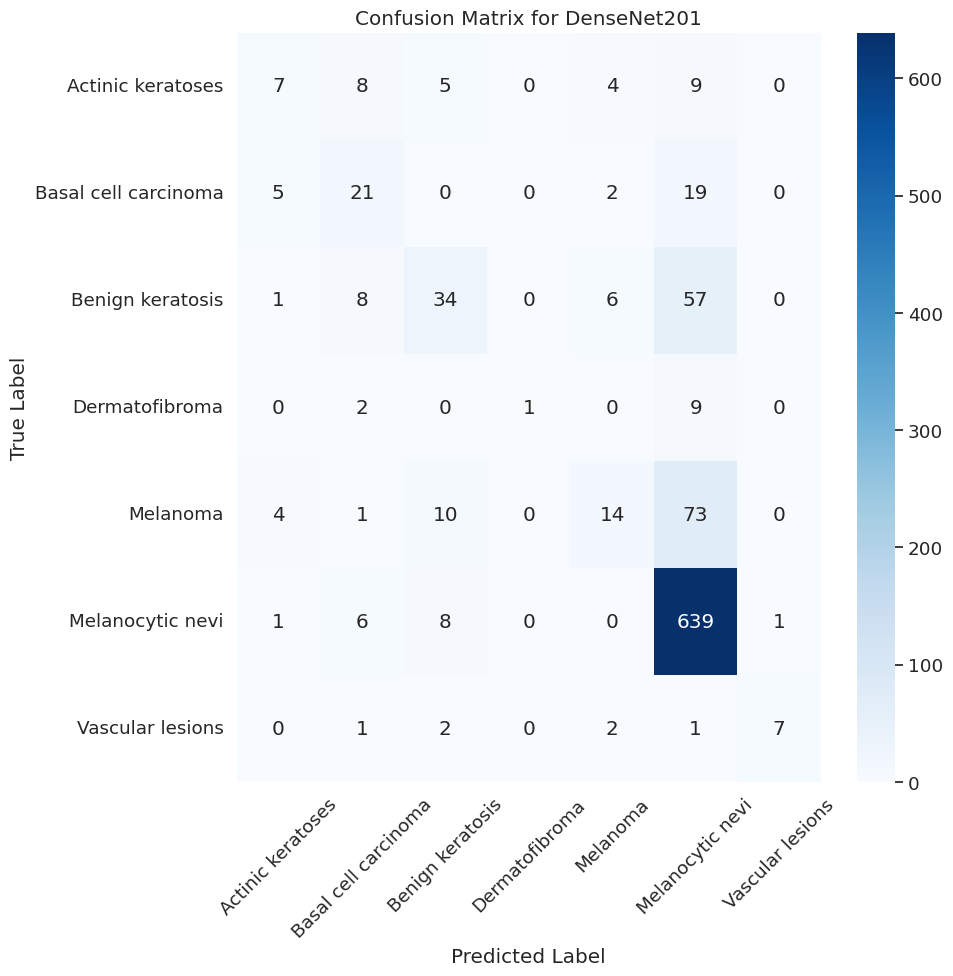


Classification Report:
                      precision    recall  f1-score   support

   Actinic keratoses       0.39      0.21      0.27        33
Basal cell carcinoma       0.45      0.45      0.45        47
    Benign keratosis       0.58      0.32      0.41       106
      Dermatofibroma       1.00      0.08      0.15        12
            Melanoma       0.50      0.14      0.22       102
    Melanocytic nevi       0.79      0.98      0.87       655
    Vascular lesions       0.88      0.54      0.67        13

            accuracy                           0.75       968
           macro avg       0.65      0.39      0.43       968
        weighted avg       0.71      0.75      0.70       968



In [22]:
for model_name, config in model_configs.items():
    print("\n================================================")
    print(f"Final Training and Evaluation for model: {model_name}")
    print("================================================")

    img_size = config["img_size"]
    use_rescale = config["use_rescale"]
    model_func = config["model_func"]

    print("\nBalancing full training data for final model...")
    balanced_df_train = balance_data(df_train, oversample=USE_AUGMENTATION_AND_OVERSAMPLING)
    print(f"Final balanced full training set size: {len(balanced_df_train)} samples")

    if use_rescale:
        train_gen_full = tr_gen_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )
    else:
        train_gen_full = tr_gen_no_rescale.flow_from_dataframe(
            balanced_df_train,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=True,
            batch_size=batch_size
        )
        test_gen = ts_gen_no_rescale.flow_from_dataframe(
            df_test,
            x_col='path',
            y_col='label',
            target_size=img_size,
            class_mode='categorical',
            color_mode='rgb',
            shuffle=False,
            batch_size=batch_size
        )

    num_classes = len(train_gen_full.class_indices)
    model = model_func(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes)
    model = compile_model(model)

    final_lr_reduction = ReduceLROnPlateau(
        monitor='accuracy',
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    print("\n--- Final training on full training data ---")
    history_full = model.fit(
        train_gen_full,
        epochs=num_epochs,
        callbacks=[final_lr_reduction],
        verbose=1
    )

    plot_training_history(history_full, model_name)

    print("\nEvaluating on test set...")
    score = model.evaluate(test_gen)
    loss, accuracy, auc_value = score
    print(f"\nTest Loss for {model_name}: {loss:.4f}")
    print(f"Test Accuracy for {model_name}: {accuracy:.4f}")
    print(f"Test AUC for {model_name}: {auc_value:.4f}")

    print("\nGenerating predictions for ROC curves...")
    y_pred = model.predict(test_gen)
    y_true = np.array(test_gen.classes)
    class_names = list(test_gen.class_indices.keys())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        y_true_binary = np.array(y_true == i, dtype=int)
        fpr[i], tpr[i], _ = roc_curve(
            y_true_binary,
            y_pred[:, i]
        )
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        tf.keras.utils.to_categorical(y_true, num_classes=num_classes).ravel(),
        y_pred.ravel()
    )
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    lesion_names = [lesion_type_dict[key] for key in class_names]
    plot_roc_curves(fpr, tpr, roc_auc, lesion_names, f"{model_name} - Test Set ROC Curves")

    print("\nGenerating confusion matrix...")
    predictions = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, predictions)

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[lesion_type_dict[key] for key in class_names],
                yticklabels=[lesion_type_dict[key] for key in class_names])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(
        y_true,
        predictions,
        target_names=[lesion_type_dict[key] for key in class_names],
        zero_division=0
    ))

    del model
    tf.keras.backend.clear_session()
    gc.collect()